## Imports

In [1]:
%autosave 120

Autosaving every 120 seconds


In [2]:
print("hi")
from transformer_lens.hook_points import HookPoint
print("tl")
import torch
from einops import rearrange
import torch
from tqdm.notebook import tqdm
from jaxtyping import Float
from dataclasses import dataclass, field
from copy import deepcopy
from typing import List
from functools import partial
from IPython.display import display, clear_output
import ipywidgets
import pathlib
from collections import defaultdict
from functools import partial
print("other")
torch.set_grad_enabled(False)

# from transformer lens
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        # Parse the PyTorch version to check if it's below version 2.0
        major_version = int(torch.__version__.split(".")[0])
        if major_version >= 2:
            return torch.device("mps")

    return torch.device("cpu")
device = get_device()
print("device", device)

# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, fix_size=False, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    if fix_size:
        # default settings aren't very good, these are better
        plot_args = {
            'width': 800,
            'height': 600,
            "autosize": False,
            'showlegend': True,
            'margin': {"l":0,"r":0,"t":100,"b":0}
        }
        if model.cfg.n_layers < len(kwargs['y']):
            plot_args['height'] *= model.cfg.D_conv
        
        fig.update_layout(**plot_args)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
    if show:
        fig.show(renderer)
    else:
        return fig

def show(data, x, xaxis, yaxis, title, clipped):
    if clipped:
        imshow(data[:,2:], x=x[2:], xaxis=xaxis, yaxis=yaxis, title=title)
    else:
        imshow(data, x=x, xaxis=xaxis, yaxis=yaxis, title=title)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()


hi
tl
other
device cuda


## Load Model

In [3]:
from mamba_lens import HookedMamba
from transformers.utils.hub import cached_file
from transformers.utils import WEIGHTS_NAME, CONFIG_NAME
import os
print(torch.cuda.is_available())
model_path = "state-spaces/mamba-370m"
print("model cached at", cached_file(model_path, WEIGHTS_NAME))
model = HookedMamba.from_pretrained(model_path, device='cuda')
#from transformer_lens import HookedTransformer
#model = HookedTransformer.from_pretrained("gpt2-large")
torch.set_grad_enabled(False)

True
model cached at /home/dev/.cache/huggingface/hub/models--state-spaces--mamba-370m/snapshots/b6c47221dc4908532cc9773d469d6b8cbe3f0762/pytorch_model.bin


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


## Utility Functions

In [4]:
def get_pad_token(tokenizer):
    return tokenizer.pad_token_id

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)

def eval_debug(model, data, correct, incorrect, constrain_to_answers, tags, batch_size, top_k=2, **kwargs):
    num_correct = 0
    num_incorrect = 0
    num_correct_tags = defaultdict(lambda: 0)
    num_incorrect_tags = defaultdict(lambda: 0)
    for batch_start in tqdm(list(range(0, correct.size()[0], batch_size))):
        batch_end = min(batch_start+batch_size, correct.size()[0])
        inputs = data[batch_start:batch_end]
        batch_logits = model(inputs, **kwargs)[:,-1]
        for b in range(batch_start, batch_end):
            logits = batch_logits[b-batch_start]
            input = model.tokenizer.decode(data[b])
            correct_answers = correct[b]
            incorrect_answers = incorrect[b]
            if constrain_to_answers:
                only_consider_answer_logits = torch.full(logits.size(), fill_value=-torch.inf, device=model.cfg.device)
                only_consider_answer_logits[correct_answers] = logits[correct_answers]
                only_consider_answer_logits[incorrect_answers] = logits[incorrect_answers]
                logits = only_consider_answer_logits
            prs = torch.nn.functional.softmax(logits, dim=0)
            top = torch.argsort(-logits)[:top_k]
            printed = False
            printed_prompt = False
            for i, tok in enumerate(top):
                if not i == 0 and tok in correct_answers:
                    if not printed_prompt:
                        if not tags is None:
                            print(tags[b])
                        print("prompt", input)
                        printed_prompt = True
                    print(f"  correct top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                    printed = True
                    #print("correct")
                    #print(f"token {model.tokenizer.decode([tok])} logit {logits[tok]} prs {prs[tok]}")
                elif i == 0 and not tok in correct_answers:
                    if not printed_prompt:
                        if not tags is None:
                            print(tags[b])
                        print("prompt", input)
                        printed_prompt = True
                    print(f"  incorrect top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                    printed = True
                if tok in correct_answers:
                    if i == 0:
                        num_correct += 1
                        if not tags is None:
                            num_correct_tags[tags[b]] += 1
                    break
                else:
                    if i == 0:
                        num_incorrect += 1
                        if not tags is None:
                            num_incorrect_tags[tags[b]] += 1
            
            if printed:
                print()
    return num_correct, num_incorrect, num_correct_tags, num_incorrect_tags

def eval(model, data, correct, incorrect, constrain_to_answers, batch_size=200, patch=False, **kwargs):
        if patch and batch_size % 2 != 0:
            raise ValueError(f"when patch=True, batch size ({batch_size}) must be a multiple of two (because every other input is patch input)")
        num_examples = correct.size()[0]
        total_num_correct = 0
        correct_prs_all = []
        incorrect_prs_all = []
        total_n_data = 0
        for batch_start in list(range(0, correct.size()[0], batch_size)):
            batch_end = min(batch_start+batch_size, correct.size()[0])
            batch_inputs = data[batch_start:batch_end]
            batch_correct = correct[batch_start:batch_end]
            batch_incorrect = incorrect[batch_start:batch_end]
            cur_batch_size = batch_inputs.size()[0]
            if patch:
                batch_correct = batch_correct[::2]
                batch_incorrect = batch_incorrect[::2]
            logits = model(batch_inputs, **kwargs)[:,-1]
            if patch:
                logits = logits[::2]
            pad = get_pad_token(tokenizer=model.tokenizer)
            logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect
            
            n_data, n_correct = batch_correct.size()
            n_data, n_incorrect = batch_incorrect.size()

            total_n_data += n_data
    
            if constrain_to_answers:
                # [n_data, n_correct]
                correct_logits = index_into(logits, batch_correct)
                # [n_data, n_incorrect]
                incorrect_logits = index_into(logits, batch_incorrect)
                # [n_data, n_correct + n_incorrect]
                combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
                combined_prs = torch.softmax(combined_logits, dim=1)
                biggest = torch.argsort(-combined_prs, dim=1)
                # if biggest pr is in the correct, we are correct, otherwise, we are not
                num_correct = torch.sum(biggest[:,0] < n_correct)
        
                correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            else:
                prs = torch.nn.functional.softmax(logits, dim=1)
                # [n_data, n_correct]
                correct_prs = index_into(prs, batch_correct)
                # [n_data, n_incorrect]
                incorrect_prs = index_into(prs, batch_incorrect)
                # [n_data, 1]
                top_tokens = torch.topk(logits, 1, dim=1).indices
                # [n_data, n_correct]
                is_correct = top_tokens == batch_correct
                # [n_data]
                has_any_correct = torch.any(is_correct, dim=1)
                # [1]
                num_correct = torch.sum(has_any_correct)
            correct_prs_all.append(correct_prs)
            incorrect_prs_all.append(incorrect_prs)
            total_num_correct += num_correct.item()
        incorrect_prs_all = torch.cat(incorrect_prs_all, dim=0)
        correct_prs_all = torch.cat(correct_prs_all, dim=0)
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs_all.sum(dim=1)).item(), torch.mean(incorrect_prs_all.sum(dim=1)).item(), total_num_correct/float(total_n_data)


def add_padding_answers(tokenizer, answers):
    longest_len = len(max(answers, key=lambda x: len(x)))
    padded_answers = []
    pad_token = get_pad_token(tokenizer=tokenizer)
    for answer in answers:
        padded_answers.append(answer + [pad_token]*(longest_len-len(answer)))
    return padded_answers

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []

    bos = [model.tokenizer.bos_token_id]
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 7:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(bos + model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_correct), device=model.cfg.device)
        batched_incorrect = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_incorrect), device=model.cfg.device)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

# because every pair (i,i+1) is a patching (uncorrupted, corrupted),
# we want things to be symmetric,
# so we will double up our dataset
# by swapping each pair
def repeat_swapped_patch(vec):
    swapped_vecs = []
    for i in range(0, vec.size()[0], 2):
        swapped_vecs += [vec[i+1:i+2], vec[i:i+1]]
    return torch.cat([vec] + swapped_vecs, dim=0)


def wrap_run_with_hooks(model, fwd_hooks, **kwargs):
    def wrapper(input, fwd_hooks):
        return model.run_with_hooks(input, fwd_hooks=fwd_hooks, **kwargs)
    wrapper_with_hooks = partial(wrapper, fwd_hooks=fwd_hooks)
    wrapper_with_hooks.tokenizer = model.tokenizer
    wrapper_with_hooks.cfg = model.cfg
    return wrapper_with_hooks

## Generate Data

In [5]:
from docstring import docstring_prompt_generator_function
from importlib import reload
import random
import test_data
reload(test_data)
from test_data import IOI_generator, BABA_TEMPLATES, greater_than_data_generator, ABC_TEMPLATES, copy_generator, IOI_custom_generator
test_data.good_names = None

num_examples = 20

seed = 28
valid_seed = 37
test_seed = 47

batch_size = 500

# todo: move name tokens further apart so they can't use conv
data_type = 'ioi custom'

constrain_to_answers = True

if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=seed)
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=valid_seed)
    test_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=test_seed)
elif data_type == 'ioi custom':
    ioi_format = """
ABC AB C
ABC AC B""".strip()
    all_formats = list(test_data.extra_pruned_abc()) # this is all the one variable patchings
    #all_formats = [ioi_format] # use this if u just want your specific format
    for f in all_formats:
        print(f)
    if len(all_formats) > 0:
        print("WARNING: Using multiple formats")
    data, valid_data, test_data = [], [], []
    random.seed(seed)
    base_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    random.seed(valid_seed)
    valid_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    random.seed(test_seed)
    test_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    for this_seed, this_valid_seed, this_test_seed, abc_format in zip(base_seeds, valid_seeds, test_seeds, all_formats):
        data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_seed))
        print(data[-2])
        print(data[-1])
        print()
        valid_data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_valid_seed))
        test_data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_test_seed))
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)
    test_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=test_seed)
elif data_type == 'greater than':
    constrain_to_answers = False
    data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    valid_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
    test_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed)
elif data_type == 'copy':
    constrain_to_answers = False
    copy_seq_len = 4
    data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=seed)
    valid_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=valid_seed)
    test_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=test_seed)

print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("\n\nvalid\n")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)
print("\n\ntest")
tbatched_data, tbatched_correct, tbatched_incorrect = get_batched_data(test_data)

relative_str = ' relative ' if constrain_to_answers else ' '

if data_type == 'ioi custom':
    data_tags = []
    for format in all_formats:
        data_tags += [format + "\n[" + format.split("\n")[0] + "]", format + "\n[" + format.split("\n")[1] + "]"] * (num_examples//2)
else:
    data_tags = None
print("evaling data")
print(len(data_tags), batched_data.size()[0])
# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            model,
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers,
                            batch_size=batch_size, patch=True)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

print("incorrect datapoints:")
# constrain_to_answers will constrain generation to only outputting those answers
num_correct, num_incorrect, num_correct_tags, num_incorrect_tags = eval_debug(
                            model,
                            batched_data, batched_correct, batched_incorrect,
                            constrain_to_answers=constrain_to_answers,
                            batch_size=batch_size,
                            tags=data_tags)
# it's okay to keep the incorrect ones around, their signal should be weak
print(f"done eval, there are {num_correct} correct (top_1) and {num_incorrect} incorrect")

if not data_tags is None:
    unique_tags = []
    for t in data_tags:
        if not t in unique_tags:
            unique_tags.append(t)
    for t in unique_tags:
        print("data format")
        print(t)
        print("has")
        acc = num_correct_tags[t] / float(num_correct_tags[t] + num_incorrect_tags[t])
        print(f"  {num_correct_tags[t]} correct and {num_incorrect_tags[t]} incorrect (so accuracy of {acc})")

CAB AB C
DAB AB D

ACB AB C
ADB AB D

ABC AB C
ABD AB D

ABC AB C
ABC AC B

ABC AC B
ABC BC A

CAB AB C
DAB AB D
ACB AB C
ADB AB D
ABC AB C
ABD AB D
ABC AB C
ABC AC B
ABC AC B
ABC BC A
good nouns {'[PLACE]': ['store', 'garden', 'restaurant', 'school', 'hospital', 'office', 'house', 'station'], '[OBJECT]': ['apple', 'kiss', 'bone', 'basketball', 'computer', 'necklace', 'drink', 'snack']}
('Lately, Lee, Marian, and Liz had fun at the garden. Marian and Liz gave a kiss to', [' Lee'], [' Liz', ' Marian', ' Cecil'])
('Lately, Cecil, Marian, and Liz had fun at the garden. Marian and Liz gave a kiss to', [' Cecil'], [' Lee', ' Liz', ' Marian'])

('Lately, Rebecca, Liz, and April had fun at the office. Rebecca and April gave a apple to', [' Liz'], [' April', ' Rebecca', ' Amanda'])
('Lately, Rebecca, Amanda, and April had fun at the office. Rebecca and April gave a apple to', [' Amanda'], [' Liz', ' April', ' Rebecca'])

('Lately, Annie, Ruby, and Katie had fun at the office. Annie and Ruby ga

  0%|          | 0/1 [00:00<?, ?it/s]

ACB AB C
ADB AB D
[ADB AB D]
prompt <|endoftext|>Lately, Shannon, Erin, and Kirby had fun at the house. Shannon and Kirby gave a bone to
  incorrect top 0 token ' Shannon' logit 16.56769371032715 prs 0.5040392279624939
  correct top 1 token ' Erin' logit 16.491710662841797 prs 0.467159628868103

ACB AB C
ADB AB D
[ADB AB D]
prompt <|endoftext|>Lately, Raf, Stephanie, and Annie had fun at the house. Raf and Annie gave a bone to
  incorrect top 0 token ' Raf' logit 16.154109954833984 prs 0.47313421964645386
  correct top 1 token ' Stephanie' logit 16.149778366088867 prs 0.4710892140865326

ACB AB C
ADB AB D
[ACB AB C]
prompt <|endoftext|>Lately, Casey, Bernie, and Donna had fun at the house. Casey and Donna gave a necklace to
  incorrect top 0 token ' Casey' logit 16.792428970336914 prs 0.7586236000061035
  correct top 1 token ' Bernie' logit 15.319270133972168 prs 0.1738767772912979

ABC AB C
ABD AB D
[ABD AB D]
prompt <|endoftext|>Lately, Else, Casey, and Amanda had fun at the office. 

## Patching

See [MambaLens](https://github.com/Phylliida/MambaLens) for a list of all the hooks available.

set `fast_conv=True` unless you are patching on conv

set `fast_ssm=True` unless you are patching on `h`, `delta`, `A_bar`, `B_bar`, or `y`

(you can set them both to False always, it'll just be slower)

There are a few special ones:

## `skip h`

This sets the hidden state contribution at the target position and layer to 0.

In other words, where normally the hidden state at that position would be

$$h_{pos+1} = Ah_{pos} + Bx$$

Now it is just

$$h_{pos+1} = Ah_{pos}$$

## `h_n`

Patches on the N different E-sized hidden states

Note that patching on `h_n` is hardcoded to layer 39 via

```
H_N_PATCHING_LAYER = 39
```

You can change this to pick a different layer

In [19]:
# modified from neel nanda's examples

H_N_PATCHING_LAYER = 39

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

#limited_layers = [0, 3, 10, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 33, 36, 39, 40, 45, 46]
limited_layers = list(range(model.cfg.n_layers))
limited_layers = list(range(40)) + [40, 45, 46]

# grab first two data points as patching inputs
# the data generators will pair things nicely
# you can also just replace these with two strings
prompt_uncorrupted = model.tokenizer.decode(batched_data[0][1:])
prompt_corrupted = model.tokenizer.decode(batched_data[1][1:])

answer_tokens = sorted(list(set([x.item() for x in batched_correct[0]] + [x.item() for x in batched_correct[1]] + [x.item() for x in batched_incorrect[0]] + [x.item() for x in batched_incorrect[1]])))
uncorrupted_answer = model.tokenizer.decode([batched_correct[0,0]])
corrupted_answer = model.tokenizer.decode([batched_correct[1,0]])

# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            wrap_run_with_hooks(model=model, fwd_hooks=[], only_use_these_layers=limited_layers),
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

min_pr_diff = corrupted_pr_diff
max_pr_diff = uncorrupted_pr_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type, patching_hook_name_func, patching_hook_func, batch_size, show_options, show_plot=True, **kwargs):
    torch.cuda.empty_cache()
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(limited_layers)

    num_results = n_layers
    if patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        num_results = N
    elif patching_type == CONV_FILTERS_PATCHING:
        D_conv = model.cfg.D_conv
        num_results = (D_conv-1)*n_layers # -1 because the zero one is always zero so we ignore it
    
    patching_result_normalized_logits = torch.zeros((num_results, L), device=model.cfg.device)
    patching_result_normalized_prs = torch.zeros((num_results, L), device=model.cfg.device)

    num_answers = len(answer_tokens)
    patching_result_logits = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    patching_result_prs = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    
    hooks = []
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    # conv filters needs conv_input (hook_in_proj) stored, so also add that hook
    if patching_type == CONV_FILTERS_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_in_proj', partial(conv_input_storage_hook, layer=layer)))
    
    if patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch)
                batch += 1
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
    elif patching_type == CONV_FILTERS_PATCHING:
        batch = 0
        indices = []
        D_conv = model.cfg.D_conv
        ind = 0
        for i, layer in list(enumerate(limited_layers)):
            for conv_filter_i in range(D_conv):
                if conv_filter_i == 0: continue # this is always zero for some reason
                for position in range(L):
                    patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                    if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                    patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch, conv_filter_i=conv_filter_i)
                    batch += 1
                    indices.append((ind,position))
                    hooks.append((patching_hook_name, patching_hook))
                ind += 1
    else:
        batch = 0
        indices = []
        for i, layer in list(enumerate(limited_layers)):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch)
                batch += 1
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))

    
    if batch_size != BATCH_SIZE_ALL:
        V = model.cfg.V
        patched_logits = torch.zeros([len(indices), L, V])
        for batch_start in tqdm(list(range(0, len(indices), int(batch_size)))):
            batch_end = min(len(indices), batch_start+int(batch_size))
            batch_hooks = hooks[batch_start:batch_end]
            cur_batch_size = batch_end-batch_start
            patched_logits[batch_start:batch_end] = model.run_with_hooks(prompt_uncorrupted_tokens.expand(cur_batch_size,L), fwd_hooks=batch_hooks, only_use_these_layers=limited_layers, **kwargs)
    else:
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens.expand(batch,L), fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
   
    # [B,L,V]
    patched_prs = torch.softmax(patched_logits, dim=2)
    print("finished patching, plotting...")
    for b, (i,position) in enumerate(indices):
        if corrupted_answer != uncorrupted_answer:
            patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                         uncorrupted_answer=uncorrupted_answer,
                                                                         corrupted_answer=corrupted_answer)
            # normalize it so
            # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
            # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
            # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
            # so now
            # 0 means that it is acting like the uncorrupted model
            # 1 means that it is acting like the corrupted model
            normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
            patching_result_normalized_logits[i, position] = normalized_patched_logit_diff
            
            # same for pr
            patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer)
            normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
            patching_result_normalized_prs[i, position] = normalized_patched_pr_diff

        for k, answer_token in enumerate(answer_tokens):
            patching_result_logits[i, position, k] = patched_logits[b,-1,answer_token]
            patching_result_prs[i, position, k] = patched_prs[b,-1,answer_token]
    
        
    if patching_type == H_N_PATCHING:
        layer_labels = [str(n) for n in range(N)]
    elif patching_type == CONV_FILTERS_PATCHING:
        layer_labels = []
        for layer in limited_layers:
            for conv_i in range(1, D_conv):
                layer_labels.append(f"layer {layer} conv {conv_i-D_conv+1}")
    else:
        layer_labels = [str(layer) for layer in limited_layers]
    figs = []
    if corrupted_answer != uncorrupted_answer:
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_logits, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_prs, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
    
    for k, answer_token in enumerate(answer_tokens):
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_logits[:,:,k], color_continuous_midpoint=None, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_prs[:,:,k], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8)) 

    for fig in figs:
        plot_args_copy = dict(list(plot_args.items()))
        if patching_type == CONV_FILTERS_PATCHING:
            plot_args_copy['height'] *= D_conv
        fig.update_layout(**plot_args_copy)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
        fig.show()

## hooks for conv filter patching
def conv_input_storage_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    global progress # it's slow enough that progress bar is useful
    if layer == 0:
        progress = tqdm(total=len(limited_layers))
    else:
        progress.update(1)
    global storage
    storage = {}
    storage['conv_input'] = conv_input
    return conv_input

def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    position: int,
    batch: int,
    conv_filter_i: int,
) -> Float[torch.Tensor, "B L E"]:
    global storage
    conv_input = storage['conv_input']
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    conv_input_corrupted = rearrange(corrupted_activations[f'blocks.{layer}.hook_in_proj'], 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    D_CONV = model.cfg.d_conv
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    # this is inefficient because its recomputing things every time
    # but I don't want to have to rely on the ordering of hooks because that's sus
    # so this is good enough
    for i in range(D_CONV):
        filter_str = f'filter_{i}'
        if not filter_str in storage:
            # [B,E,L]                      [E,1]                      [B,E,L]
            filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L]
            storage[filter_str] = filter_contribution
        filter_contribution = storage[filter_str]
        if i == conv_filter_i:
            # [1,E,L]                                   [E,1]                          # [1,E,L]
            corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_corrupted[:,:,i:i+L]
            # [E]                                                    [E]
            filter_contribution[batch,:,position] = corrupted_filter_contribution[0,:,position]
        storage[filter_str] = filter_contribution
        output += filter_contribution
        #output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input

    # bias is not dependent on input so no reason to patch on it, just apply it as normal
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output



## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_x = corrupted_activations[hook.name]
    x[batch, position, :] = corrupted_x[0, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch] = corrupted_h[0]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch,:,n] = corrupted_h[0,:,n]
    return h

SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'
CONV_FILTERS_PATCHING = 'conv filters'

patching_types = {
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    CONV_FILTERS_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_conv', conv_patching_hook),
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)

def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     batch_size=choose_batch_size.batch_size,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     show_plot=show_plot)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)

IndexError: index 100 is out of bounds for dimension 0 with size 100

## Attention map like stuff

In [25]:

def cosine_similarity(vec1, vec2):
    B = vec1.size()[0]
    vec1 = vec1.reshape(B,-1)
    vec2 = vec2.reshape(B,-1)
    my_mag = torch.linalg.norm(vec1, ord=2, dim=1)
    my_mag[my_mag == 0] = 1.0 # prevent divide by zero
    other_mag = torch.linalg.norm(vec2, ord=2, dim=1)
    other_mag[other_mag == 0] = 1.0 # prevent divide by zero
    prod = vec1 * vec2
    dot_prod = prod.sum(dim=1)
    sims = dot_prod * (1.0/my_mag) * (1.0/other_mag)
    return torch.mean(sims, dim=0)


B,L = batched_data.size()
limited_layers = list(range(model.cfg.n_layers))
n_layers = len(limited_layers)
names_filter = []
for layer in limited_layers:
    names_filter.append(f'blocks.{layer}.hook_A_bar')
    names_filter.append(f'blocks.{layer}.hook_B_bar')
    names_filter.append(f'blocks.{layer}.hook_ssm_input')
    for l in range(L):
        names_filter.append(f'blocks.{layer}.hook_h.{l}')
        
logits, activations = model.run_with_cache(batched_data, names_filter=names_filter)

h_similarities = torch.zeros([n_layers, L, L])
x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities_catchup = torch.zeros([n_layers, L, L])
E,N = model.cfg.E, model.cfg.N
for i, layer in tqdm(list(enumerate(limited_layers))):
    # [B,L,E,N]
    A_bar = activations[f'blocks.{layer}.hook_A_bar']
    # [B,L,E,N]
    B_bar = activations[f'blocks.{layer}.hook_B_bar']
    # [B,L,E]
    x = activations[f'blocks.{layer}.hook_ssm_input']
    # [B,L,E,N]
    x_b = x.view(B,L,E,1)*B_bar
    for pos in range(L):
        my_h = activations[f'blocks.{layer}.hook_h.{pos}']
        my_x_b = x_b[:,pos,:,:]
        for other_pos in range(L):
            other_h = activations[f'blocks.{layer}.hook_h.{other_pos}']
            other_x_b = x_b[:,other_pos,:,:]
            h_similarities[i,pos,other_pos] = cosine_similarity(my_h, other_h)
            x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_x_b)
            h_to_x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_h)
            my_x_b_catchuped = my_x_b
            for catchup_pos in range(pos+1, other_pos+1):
                my_x_b_catchuped = my_x_b_catchuped * A_bar[:,catchup_pos]
            h_to_x_b_similarities_catchup[i,pos,other_pos] = cosine_similarity(my_x_b_catchuped, other_h)
            #if pos == other_pos: continue
            #other_h = h_from_x[:,other_pos,:,:]
            #for catchup_pos in range(other_pos+1, pos+1):
            #    other_h_catchuped = other_h_catchuped * A_bar[:,catchup_pos]
            # [B,E,N]

            #my_mag = torch.linalg.norm(my_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #my_mag[my_mag == 0] = 1.0 # prevent divide by zero
            #other_mag = torch.linalg.norm(other_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #other_mag[other_mag == 0] = 1.0 # prevent divide by zero
            # [B]
            # [B]
            #cosine_similarity = dot_prod * (1.0/other_mag) * (1.0/my_mag)
            #
# cleanup
del activations
del logits
torch.cuda.empty_cache()

  0%|          | 0/48 [00:00<?, ?it/s]

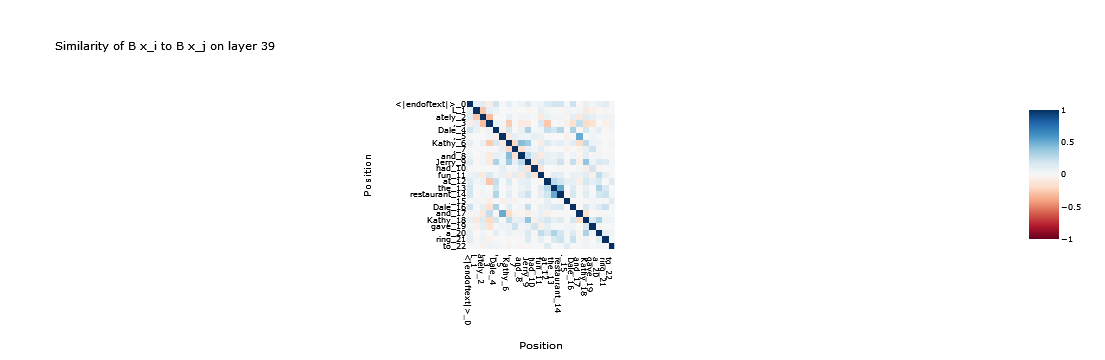

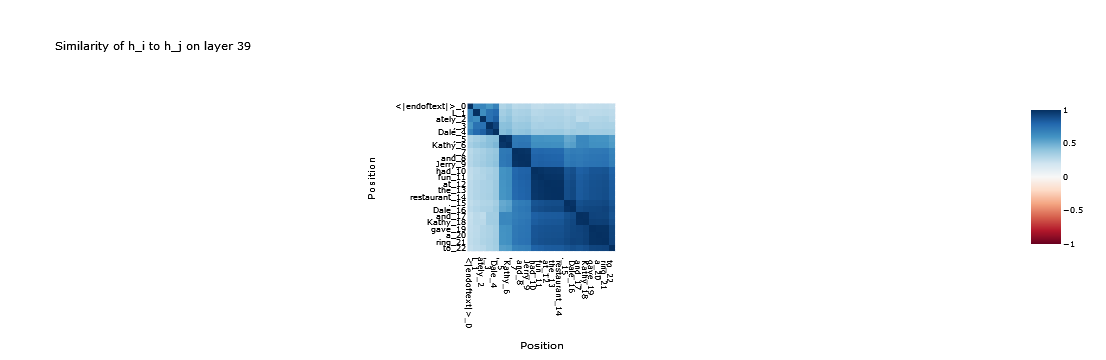

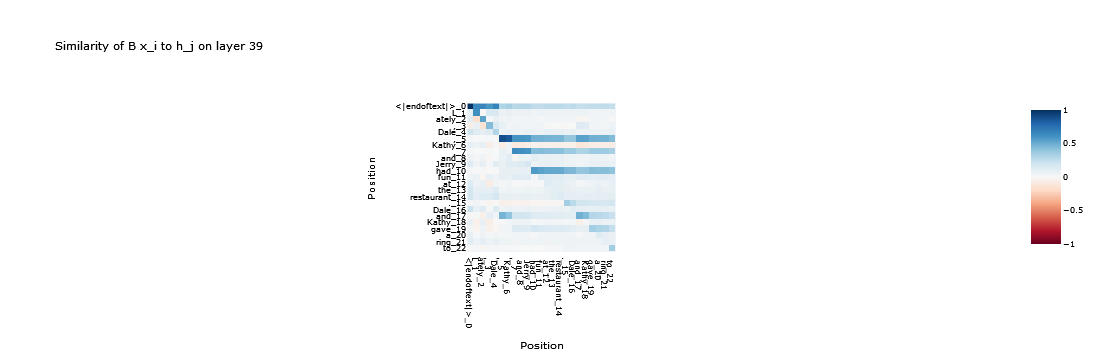

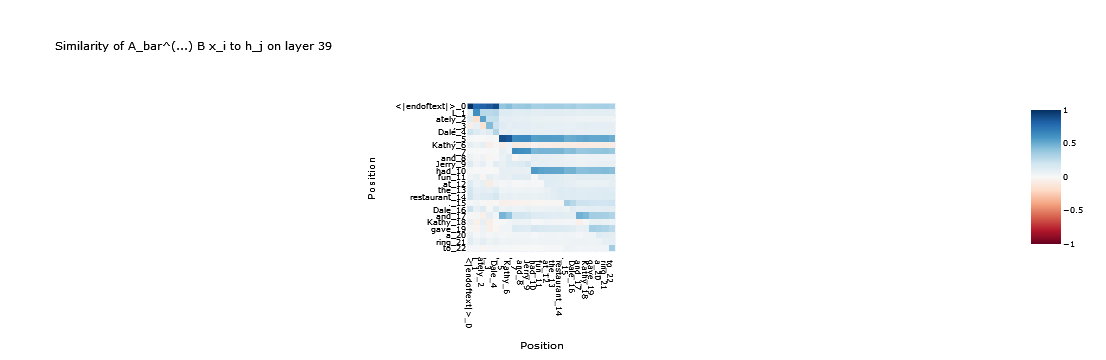

In [26]:

prompt = model.tokenizer.decode(batched_data[0][1:])
prompt_tokens = model.to_tokens(prompt)[0]
L = prompt_tokens.size()[0]
prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

# for each pos
'''
layer_labels = [str(layer) for layer in limited_layers]
for pos in tqdm(list(range(L))):
    fig = imshow(h_to_x_b_similarities[:,pos], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Similarity to hidden state of token = {token_labels[pos]}", font_size=8)
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    fig.show()
'''
LAYER = 39
imshow(x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to B x_j on layer {LAYER}", font_size=8).show()
imshow(h_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of h_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities_catchup[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of A_bar^(...) B x_i to h_j on layer {LAYER}", font_size=8).show()



## Interpreting Convs

In [17]:
TOP_N = 200


def get_conv_sims(all_tokens, layer_input_func):
    V,L,D,E = all_tokens.size()[0], 1, model.cfg.D, model.cfg.E
    D_conv = model.cfg.D_conv
    sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    cosine_sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    
    # todo: can we do the same thing for skip connection and B_bar (and maybe A_bar?)
    for INTERPRET_LAYER in tqdm(list(range(model.cfg.n_layers))):
        # [V,1,E]
        conv_input = layer_input_func(all_tokens=all_tokens, layer=INTERPRET_LAYER)
        # [E,1,D_CONV]
        conv_filters = model.blocks[INTERPRET_LAYER].conv1d.weight
        # [V,D]
        conv_input_vecs = conv_input[:,0,:]
        # [V,1]
        conv_input_vecs_mag = torch.linalg.norm(conv_input_vecs, ord=2, dim=1, keepdim=True)
        conv_input_vecs_mag[conv_input_vecs_mag==0] = 1.0 # prevent divide by zero
        # [V,D]                     [V,D]             [V,1]
        conv_input_normalized = conv_input_vecs * 1.0/conv_input_vecs_mag
        
        for conv_i in range(D_conv+1):
            if conv_i < D_conv:
                # [E,1]
                filter = conv_filters[:,0,conv_i].view(E,1)
            else:
                filter = model.blocks[INTERPRET_LAYER].conv1d.bias.view(E,1)
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_sims    = conv_input @ filter
            # [V]                                  [V]
            sims[INTERPRET_LAYER,:,conv_i] = filter_sims[:,0,0]
        
            # [1]
            filter_mag = torch.linalg.norm(filter.view(E), ord=2, dim=0, keepdim=True)
            filter_mag[filter_mag==0] = 1.0 # no divide by zero
            # [E,1]              [E,1]      [1]
            filter_normalized = filter / filter_mag
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_cosine_sims    = conv_input_normalized.view(V,1,E) @ filter_normalized
            cosine_sims[INTERPRET_LAYER,:,conv_i] = filter_cosine_sims[:,0,0]
    return sims, cosine_sims

def simple_projected_input(all_tokens, layer):
    # [V,L,D]
    V = all_tokens.size()[0]
    L = 1
    D = model.cfg.D
    input = model.embedding.weight[all_tokens].view(V,L,D)
    # [V,L,D]                                  [V,L,D]
    normalized_input = model.blocks[layer].norm(input)
    # [V,L,E]                        [D->E]     [V,L,D]
    conv_input = model.blocks[layer].in_proj(normalized_input)
    return conv_input

all_tokens = torch.arange(model.cfg.V, device=model.cfg.device)
print(all_tokens.size())
sims, cosine_sims = get_conv_sims(all_tokens=all_tokens, layer_input_func=simple_projected_input)

import pathlib

pathlib.Path("conv interp").mkdir(parents=True, exist_ok=True)
D_conv = model.cfg.D_conv
for INTERPRET_LAYER in range(model.cfg.n_layers):
    with open(f"conv interp/layer {INTERPRET_LAYER} conv sims all.txt", "w") as f:
        def write(s):
            f.write(s + "\n")
        write(f"layer {INTERPRET_LAYER}")
        for conv_i in range(D_conv+1):
            if conv_i == 0: continue # this one is always zeros for some reason
            if conv_i < D_conv:
                write(f"    conv filter {conv_i}")
            else:
                write(f"    bias")
            write(f"      unnormalized sims:")
            top_n = torch.argsort(-sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {sims[INTERPRET_LAYER,tok_i,conv_i]}")
            write(f"      cosine sims:")
            top_n = torch.argsort(-cosine_sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {cosine_sims[INTERPRET_LAYER,tok_i,conv_i]}")
        

torch.Size([50280])


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

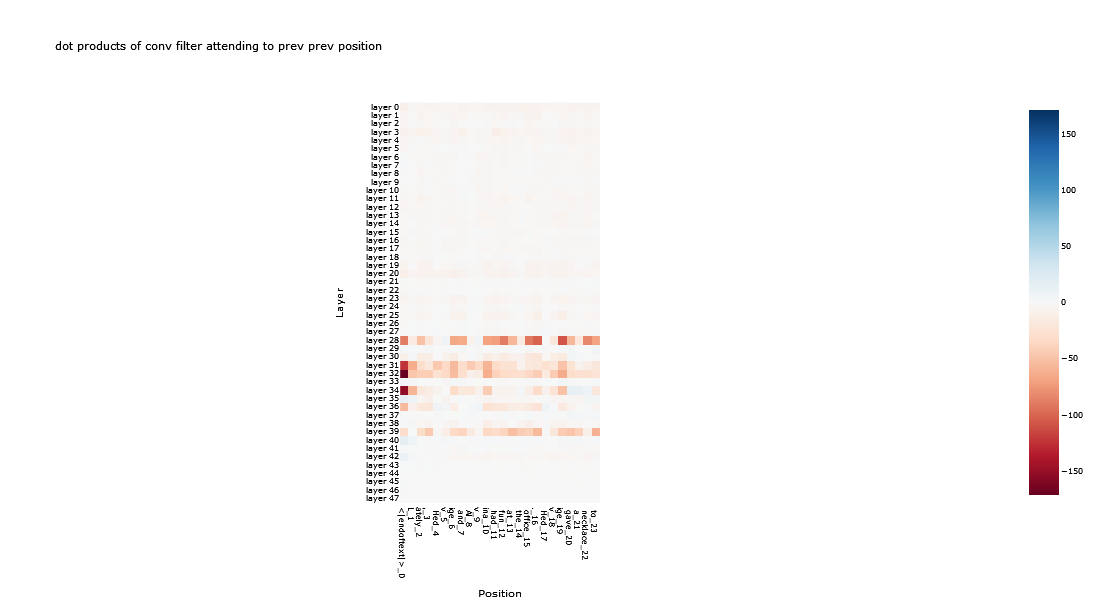

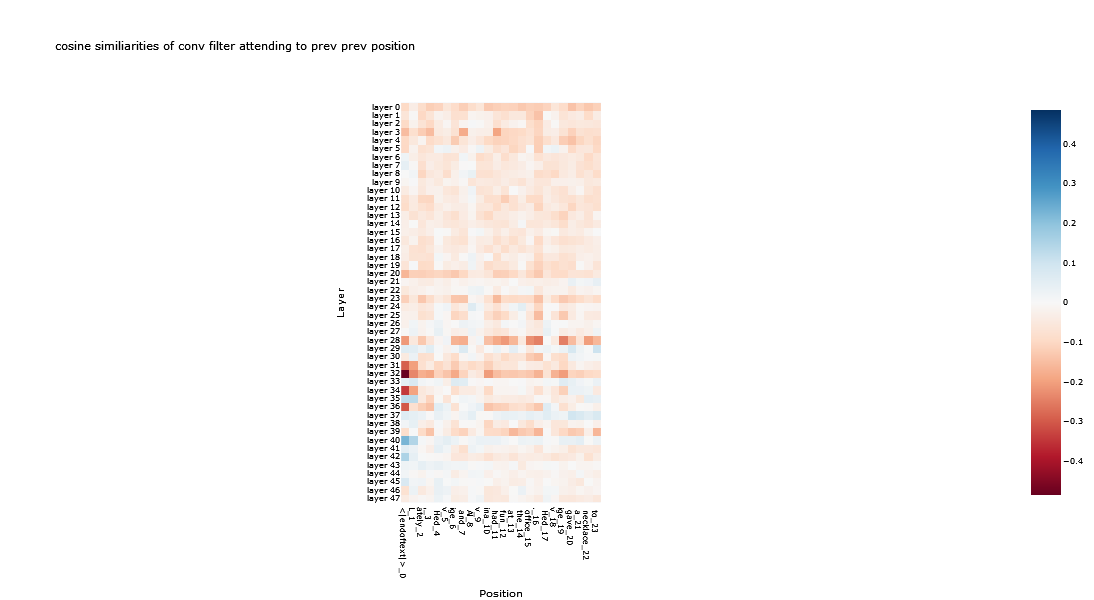

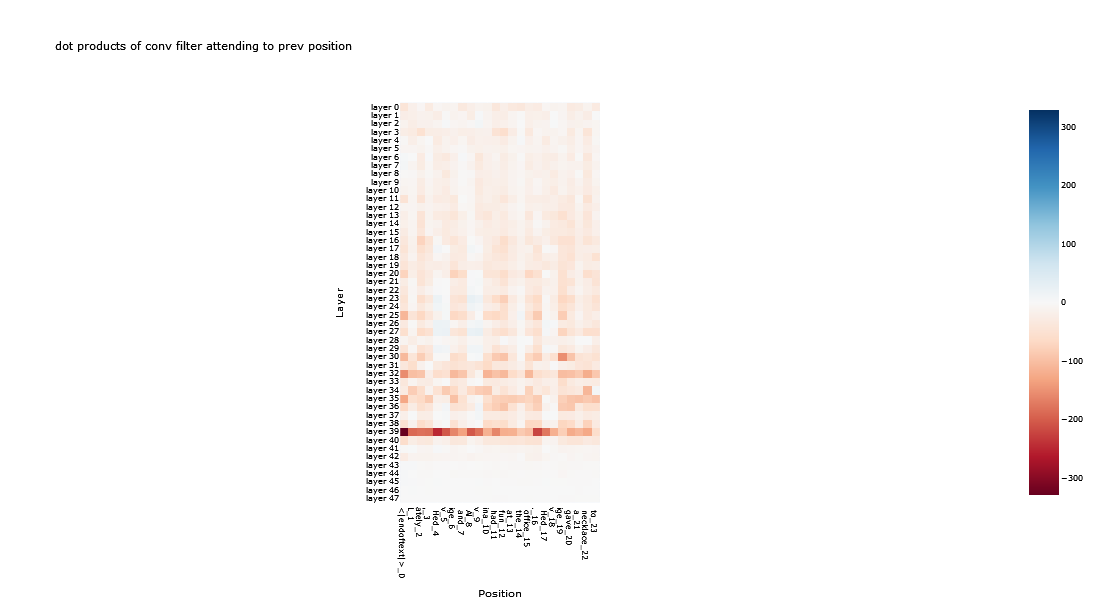

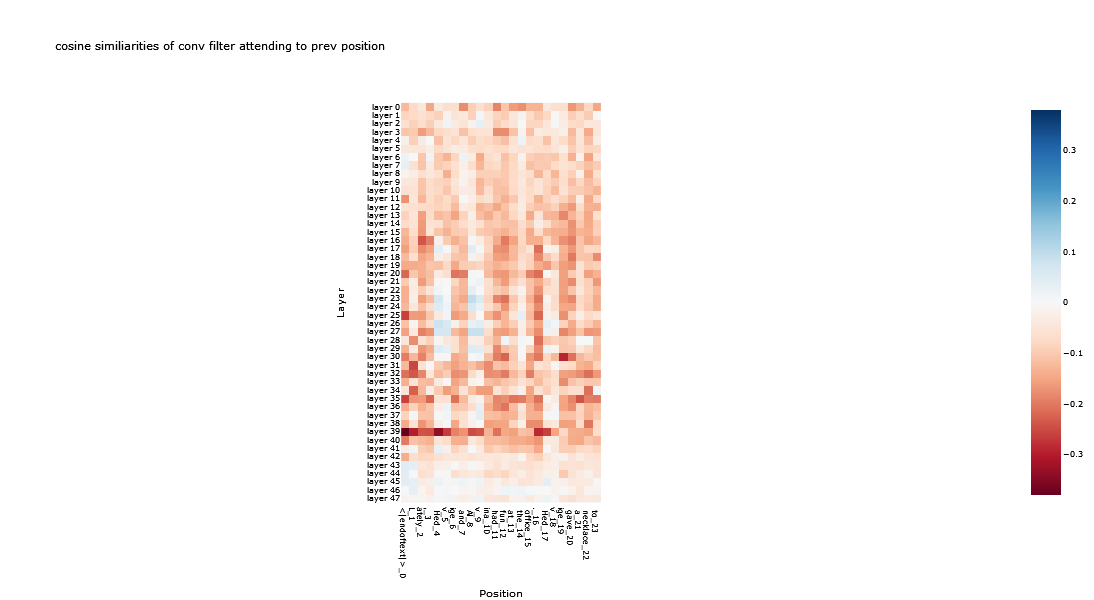

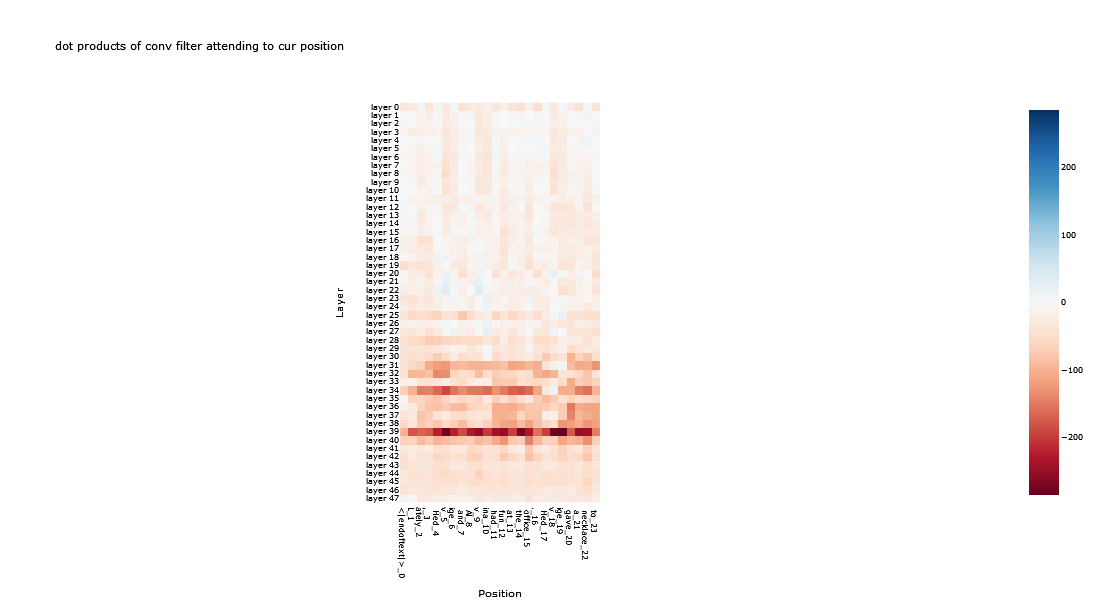

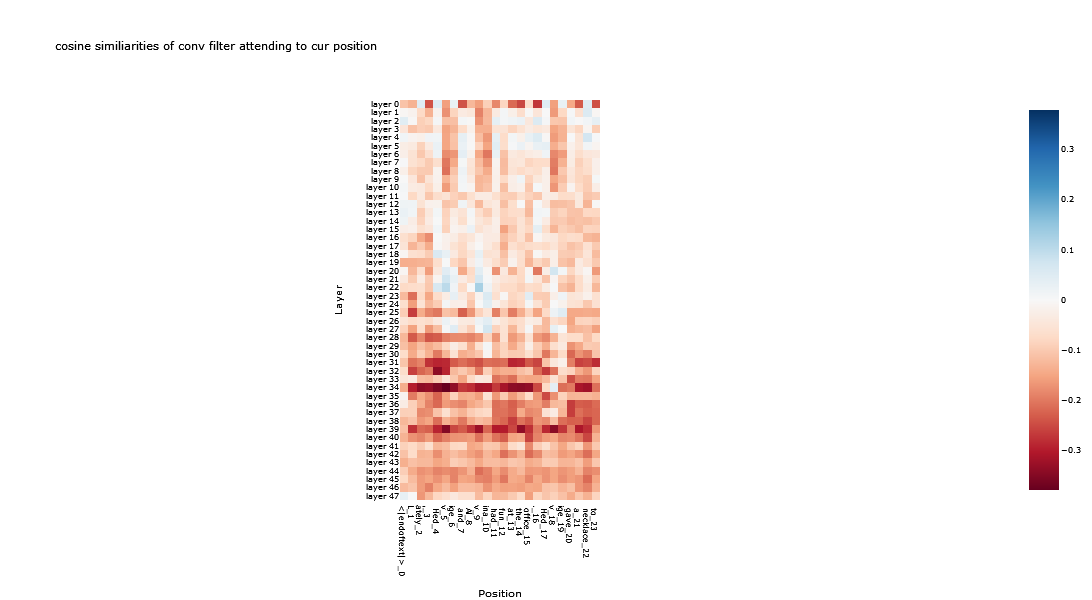

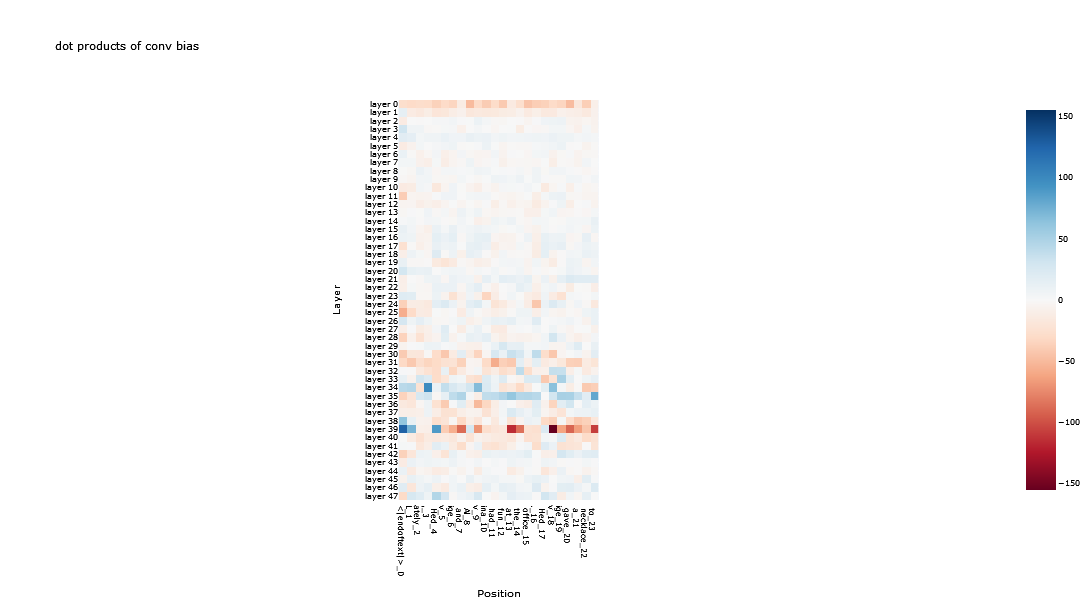

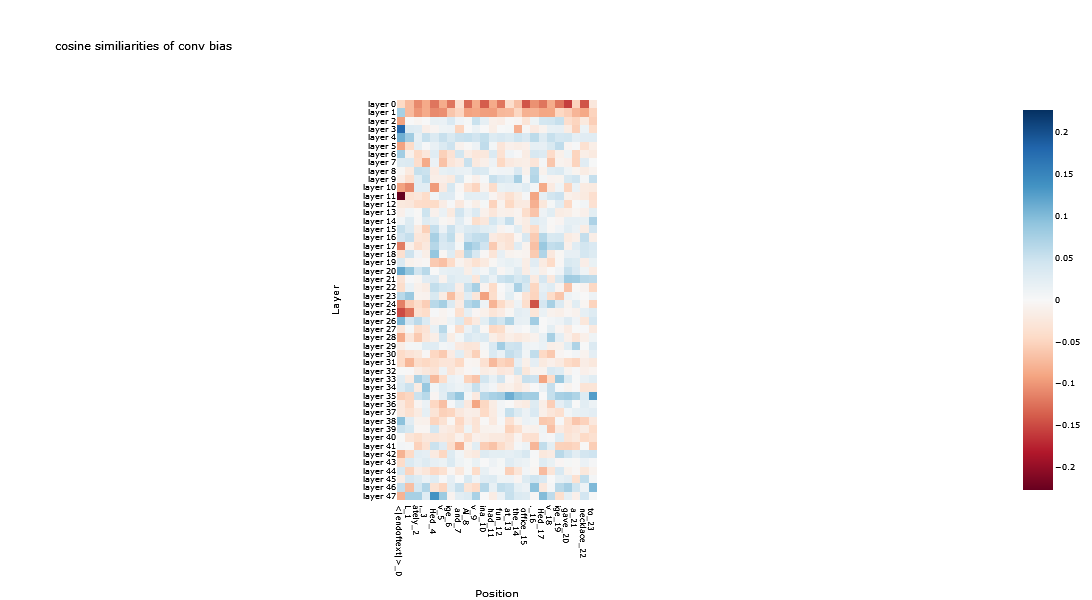

In [18]:
prompt = model.tokenizer.decode(batched_data[0][1:])
prompt_tokens = model.to_tokens(prompt)[0]
L = prompt_tokens.size()[0]
prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

in_proj_names = []
for layer in range(model.cfg.n_layers):
    in_proj_names.append(f'blocks.{layer}.hook_in_proj')
logits, activations = model.run_with_cache(prompt_tokens.view(1,-1), names_filter=in_proj_names)

def hooked_layer_inputs(all_tokens, layer):
    # [B,L,E]
    conv_input = activations[f'blocks.{layer}.hook_in_proj']
    B,L,E = conv_input.size()
    return conv_input[0].view(L,1,E)
    
all_tokens = prompt_tokens

sims, cosine_sims = get_conv_sims(all_tokens=prompt_tokens, layer_input_func=hooked_layer_inputs)

conv_name_lookup = ['conv filter attending to cur position', 'conv bias']
for i in range(D_conv-1):
    conv_name_lookup = ["conv filter attending to " + " ".join(['prev']*(i+1)) + " position"] + conv_name_lookup
layer_labels = [f"layer {i}" for i in range(model.cfg.n_layers)]
for conv_i in range(D_conv+1):
    if conv_i == 0: continue # the first conv is always zero for some reason
    conv_str = f"{conv_name_lookup[conv_i]}"
    imshow(sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"dot products of {conv_str}", font_size=8)
    imshow(cosine_sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"cosine similiarities of {conv_str}", font_size=8)



## Batched Patching

In [56]:
# modified from neel nanda's examples

# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
model.remove_all_hook_fns()

H_N_PATCHING_LAYER = 39
BATCH_SIZE = 10000

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

#limited_layers = [0, 3, 10, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 33, 36, 39, 40, 45, 46]
limited_layers = list(range(model.cfg.n_layers))
#limited_layers = [0, 3, 7, 10, 11, 14, 15, 16, 17, 19, 21, 23, 25, 26, 27, 28, 30, 33, 34, 39, 40, 45, 46, 47]
#limited_layers = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]
#limited_layers = list(range(40)) + [40, 45, 46]
limited_layers = [0, 1, 7, 12, 16, 18, 20, 21, 24, 28, 33, 39, 44, 45]

limited_layers = [0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

# grab first two data points as patching inputs
# the data generators will pair things nicely
# you can also just replace these with two strings
prompt_uncorrupted = model.tokenizer.decode(batched_data[0][1:])
prompt_corrupted = model.tokenizer.decode(batched_data[1][1:])

answer_tokens = sorted(list(set([x.item() for x in batched_correct[0]] + [x.item() for x in batched_correct[1]] + [x.item() for x in batched_incorrect[0]] + [x.item() for x in batched_incorrect[1]])))
uncorrupted_answer = model.tokenizer.decode([batched_correct[0,0]])
corrupted_answer = model.tokenizer.decode([batched_correct[1,0]])

# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            wrap_run_with_hooks(model=model, fwd_hooks=[], only_use_these_layers=limited_layers),
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus



# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type, patching_hook_name_func, patching_hook_func, batch_size, show_options, layers_to_patch_on, patch_positions=None, show_plot=True, **kwargs):
    torch.cuda.empty_cache()
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(layers_to_patch_on)

    num_results = n_layers
    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        num_results = n_layers
    elif patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        num_results = N
    elif patching_type == CONV_FILTERS_PATCHING:
        D_conv = model.cfg.D_conv
        num_results = (D_conv-1)*n_layers # -1 because the zero one is always zero so we ignore it
    
    num_data_points = batched_data.size()[0]//2

    if patch_positions is None:
        patch_positions = list(range(L))
        
    num_positions = len(patch_positions)

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        num_positions = n_layers # does layer x layer
    
    patching_result_normalized_logits = torch.zeros((num_data_points, num_results, num_positions), device=model.cfg.device)
    patching_result_normalized_prs = torch.zeros((num_data_points, num_results, num_positions), device=model.cfg.device)

    num_answers = len(answer_tokens)
    patching_result_logits = torch.zeros((num_data_points, num_results, num_positions, num_answers), device=model.cfg.device)
    patching_result_prs = torch.zeros((num_data_points, num_results, num_positions, num_answers), device=model.cfg.device)
    
    hooks = []

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_out_proj', partial(layer_output_storage_acdc_layer_edge_hook, layer=layer)))
        
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    # conv filters needs conv_input (hook_in_proj) stored, so also add that hook
    if patching_type == CONV_FILTERS_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_in_proj', partial(conv_input_storage_hook, layer=layer)))

    BATCH_OFFSET = 2 # first two are for uncorrupted and corrupted

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        batch = 0
        indices = []
        for i,input_layer in enumerate(layers_to_patch_on):
            for j,output_layer in enumerate(layers_to_patch_on):
                patching_hook_name = patching_hook_name_func(layer=output_layer, position=None)
                if input_layer >= output_layer: continue # only do i->j where i < j
                patching_hook = partial(patching_hook_func, input_layer=input_layer, output_layer=output_layer, batch=batch+BATCH_OFFSET)
                indices.append((i,j))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
    elif patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in patch_positions:
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch+BATCH_OFFSET)
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
    elif patching_type == CONV_FILTERS_PATCHING:
        batch = 0
        indices = []
        D_conv = model.cfg.D_conv
        ind = 0
        for i, layer in enumerate(layers_to_patch_on):
            for conv_filter_i in range(D_conv):
                if conv_filter_i == 0: continue # this is always zero for some reason
                for position in patch_positions:
                    patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                    patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch+BATCH_OFFSET, conv_filter_i=conv_filter_i)
                    indices.append((ind,position))
                    hooks.append((patching_hook_name, patching_hook))
                    batch += 1
                    if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                ind += 1
    else:
        batch = 0
        indices = []
        for i, layer in enumerate(layers_to_patch_on):
            for position in patch_positions:
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch+BATCH_OFFSET)
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)

    for uncorrupted_i in tqdm(list(range(0,batched_data.size()[0],2))):
        corrupted_i = uncorrupted_i+1
        result_i = uncorrupted_i//2
        # [1+len(indicies),L]
        uncorrupted_data = batched_data[uncorrupted_i:uncorrupted_i+1]
        corrupted_data = batched_data[corrupted_i:corrupted_i+1]
            
        if batch_size != BATCH_SIZE_ALL:
            run_data = torch.cat([uncorrupted_data, corrupted_data, uncorrupted_data.repeat((int(batch_size),1))], dim=0)
            V = model.cfg.V
            patched_logits = torch.zeros([len(indices)+2, L, V])
            for batch_start in tqdm(list(range(0, len(indices), int(batch_size)))):
                batch_end = min(len(indices), batch_start+int(batch_size))
                batch_hooks = hooks[batch_start:batch_end]
                cur_batch_size = batch_end-batch_start
                output_logits = model.run_with_hooks(run_data, fwd_hooks=batch_hooks, only_use_these_layers=limited_layers, **kwargs)
                if batch_start == 0:
                    patched_logits[0:2] = output_logits[:2]
                patched_logits[batch_start+2:batch_end+2] = output_logits[2:][:cur_batch_size] # skip the first two which are for uncorrupted and corrupted
        else:
            run_data = torch.cat([uncorrupted_data, corrupted_data, uncorrupted_data.repeat((len(indices),1))], dim=0)
            # [B,L,V]
            patched_logits = model.run_with_hooks(run_data, fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
       
        # [B,L,V]
        patched_prs = torch.softmax(patched_logits, dim=2)

        # [B,L,V]
        uncorrupted_logits = patched_logits[0:1]
        uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
        uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

        # [B,L,V]
        corrupted_logits = patched_logits[1:2]
        corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        corrupted_prs = torch.softmax(corrupted_logits, dim=2)
        corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        
        
        for b_, (i,position) in enumerate(indices):
            b = b_+2 # the first and second position is reserved for uncorrupted and corrupted, respectively
            if corrupted_answer != uncorrupted_answer:
                # diff is logit of uncorrupted_answer - logit of corrupted_answer
                # we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
                # we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
                # thus we can treat these as (rough) min and max possible values

                min_logit_diff = corrupted_logit_diff
                max_logit_diff = uncorrupted_logit_diff
                
                min_pr_diff = corrupted_pr_diff
                max_pr_diff = uncorrupted_pr_diff

                
                patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                             uncorrupted_answer=uncorrupted_answer,
                                                                             corrupted_answer=corrupted_answer)
                # normalize it so
                # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
                # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
                normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
                # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
                # so now
                # 0 means that it is acting like the uncorrupted model
                # 1 means that it is acting like the corrupted model
                normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
                patching_result_normalized_logits[uncorrupted_i//2, i, position] += normalized_patched_logit_diff
                
                # same for pr
                patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                    uncorrupted_answer=uncorrupted_answer,
                                                                    corrupted_answer=corrupted_answer)
                normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
                patching_result_normalized_prs[uncorrupted_i//2, i, position] += normalized_patched_pr_diff
    
            for k, answer_token in enumerate(answer_tokens):
                patching_result_logits[uncorrupted_i//2, i, position, k] += patched_logits[b,-1,answer_token]
                patching_result_prs[uncorrupted_i//2, i, position, k] += patched_prs[b,-1,answer_token]

    if show_plot:
        print("done patching, displaying results...")
 
        if patching_type == H_N_PATCHING:
            layer_labels = [str(n) for n in range(N)]
        elif patching_type == CONV_FILTERS_PATCHING:
            layer_labels = []
            for layer in layers_to_patch_on:
                for conv_i in range(1, D_conv):
                    layer_labels.append(f"layer {layer} conv {conv_i-D_conv+1}")
        else:
            layer_labels = [str(layer) for layer in layers_to_patch_on]
        figs = []
        points_per_data_format = num_data_points//len(all_formats)
        for data_i, data_start in enumerate(range(0, num_data_points, points_per_data_format)):
            data_end = data_start+points_per_data_format

            # make token labels that describe the patch
            uncorrupted_str_tokens = model.to_str_tokens(batched_data[data_start*2])
            corrupted_str_tokens = model.to_str_tokens(batched_data[data_start*2+1])
            token_labels = []
            for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
                if corrupted_token == uncorrupted_token:
                    token_labels.append(f"{corrupted_token}_{index}")
                else:
                    token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

            # this just does layer x layer
            if patching_type == ACDC_LAYER_EDGE_PATCHING:
                token_labels = [str(layer) for layer in layers_to_patch_on] 
            
            # this annotation describes the patching format on the side
            ANNOTATION_FONT_SIZE = 10
            def add_annotation(fig, annotation):
                for i, line in enumerate(annotation.split("\n")):
                    fig.add_annotation(dict(font=dict(color='black',size=ANNOTATION_FONT_SIZE),
                                        x=0,
                                        y=0.9-i*0.05,
                                        showarrow=False,
                                        text=line,
                                        textangle=0,
                                        xanchor='left',
                                        yanchor='bottom',
                                        xref="paper",
                                        yref="paper"))
            
            if corrupted_answer != uncorrupted_answer:
                if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                    figs.append(imshow(patching_result_normalized_logits[data_start:data_end].mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
                    add_annotation(figs[-1], all_formats[data_i])
                if show_options in [SHOW_PR, SHOW_BOTH]:
                    figs.append(imshow(patching_result_normalized_prs[data_start:data_end].mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
                    add_annotation(figs[-1], all_formats[data_i])
            data_format = all_formats[data_i]
            format_path = "patching_outputs/" + data_format.replace("\n", "   ")
            pathlib.Path(format_path).mkdir(parents=True, exist_ok=True)
            figs[-1].write_image(format_path + "/" + patching_type + ".png")

        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_logits.mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
            add_annotation(figs[-1], "average")
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_prs.mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
            add_annotation(figs[-1], "average")
        
        for k, answer_token in enumerate(answer_tokens):
            if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                figs.append(imshow(patching_result_logits.mean(dim=0)[:,:,k], fix_size=True, color_continuous_midpoint=None, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8))
            if show_options in [SHOW_PR, SHOW_BOTH]:
                figs.append(imshow(patching_result_prs.mean(dim=0)[:,:,k], fix_size=True, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8)) 
    
        for fig in figs:
            fig.show()
    return patching_result_normalized_logits, patching_result_normalized_prs, patching_result_logits, patching_result_prs

CORRUPTED_BATCH = 1

## hooks for conv filter patching
def conv_input_storage_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    global storage
    storage = {}
    storage['conv_input'] = conv_input
    return conv_input

def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    position: int,
    batch: int,
    conv_filter_i: int,
) -> Float[torch.Tensor, "B L E"]:
    
    global storage
    conv_input = storage['conv_input']
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    D_CONV = model.cfg.d_conv
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    # this is inefficient because its recomputing things every time
    # but I don't want to have to rely on the ordering of hooks because that's sus
    # so this is good enough
    for i in range(D_CONV):
        filter_str = f'filter_{i}'
        if not filter_str in storage:
            # [B,E,L]                      [E,1]                      [B,E,L]
            filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L]
            storage[filter_str] = filter_contribution
        filter_contribution = storage[filter_str]
        if i == conv_filter_i:
            # [E,L]                                   [E,1]                             [E,L]
            corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[CORRUPTED_BATCH,:,i:i+L]
            # [E]                                                    [E]
            filter_contribution[batch,:,position] = corrupted_filter_contribution[:,position]
        storage[filter_str] = filter_contribution
        output += filter_contribution
        #output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input

    # bias is not dependent on input so no reason to patch on it, just apply it as normal
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output



## hooks for ACDC layer edge step
def layer_input_acdc_layer_edge_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    input_layer: int,
    output_layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    input_resid_uncorrupted = storage[input_layer][0]
    input_resid_corrupted = storage[input_layer][1]
    layer_input_out = layer_input.clone()
    # remove the uncorrupted and add the corrupted
    layer_input[batch] = layer_input[batch]-input_resid_uncorrupted+input_resid_corrupted
    return layer_input

# hook_out_proj is the term added to the resid
def layer_output_storage_acdc_layer_edge_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    if layer == 0:
        storage = {}
    storage[layer] = layer_output[:2] # first two are uncorrupted and corrupted, we only need those nothing else
    return layer_output





## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
    position: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    x[batch, position, :] = x[CORRUPTED_BATCH, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    h[batch] = h[CORRUPTED_BATCH]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    h[batch,:,n] = h[CORRUPTED_BATCH,:,n]
    return h

SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'
CONV_FILTERS_PATCHING = 'conv filters'
ACDC_LAYER_EDGE_PATCHING = 'acdc layer edge'

patching_types = {
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    CONV_FILTERS_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_conv', conv_patching_hook),
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
    ACDC_LAYER_EDGE_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_layer_input', layer_input_acdc_layer_edge_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)
def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     batch_size=choose_batch_size.batch_size,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     layers_to_patch_on=limited_layers,
                     show_plot=show_plot)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)


# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)


baseline correct relative pr 0.88313889503479 incorrect relative pr 0.11686116456985474 accuracy 0.94
uncorrupted prompt
Lately, Chelsea, Olive, and Pam had fun at the house. Olive and Pam gave a necklace to
' Chelsea' logit 8.68609619140625
' Chelsea' pr 0.01681513525545597
' Kate' logit 4.2361249923706055
' Kate' pr 0.00019638234516605735

corrupted prompt
Lately, Kate, Olive, and Pam had fun at the house. Olive and Pam gave a necklace to
' Chelsea' logit 4.425915718078613
' Chelsea' pr 0.0001280609576497227
' Kate' logit 10.91490650177002
' Kate' pr 0.08424606919288635


Dropdown(description='Patching Type', options=('normalized input', 'layer input', 'skip', 'in proj', 'conv fil…

Dropdown(description='batch size', options=('all', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11…

Dropdown(description='fast conv', options=('True', 'False'), value='True')

Dropdown(description='fast ssm', options=('False', 'True'), value='False')

Dropdown(description='logits or pr', options=('Logits', 'Pr', 'Both'), value='Logits')

Button(description='Run Patching', style=ButtonStyle())

Output()

## Layer Patching

In [29]:

BATCH_SIZE = 1000

# todo: double up things but swapped, so it's symmetric
def patch_layer_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B L D"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, layer_output.size()[0], 2):
        layer_output[i] = layer_output[i+1]
    return layer_output

#limited_layer_set = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]

def wrap_patch_specific_layers(model, layers_to_patch, **kwargs):
    hooks = []
    for layer in layers_to_patch:
        hooks.append((f"blocks.{layer}.hook_out_proj", patch_layer_hook))
    
    def wrapper(input):
        return model.run_with_hooks(input, fwd_hooks=hooks, **kwargs)
    wrapper.tokenizer = model.tokenizer
    wrapper.cfg = model.cfg
    return wrapper

print(f"constraining output to answers? {constrain_to_answers}")

print(f"num layers {model.cfg.n_layers}")

        
pbatched_data = repeat_swapped_patch(batched_data)
pbatched_correct = repeat_swapped_patch(batched_correct)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect)
vpbatched_data = repeat_swapped_patch(vbatched_data)
vpbatched_correct = repeat_swapped_patch(vbatched_correct)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect)


history = []
history_stats = []
layers_to_patch = []

while len(layers_to_patch) < model.cfg.n_layers:
    remaining_layers = list(range(model.cfg.n_layers))
    for layer in layers_to_patch:
        remaining_layers.remove(layer)
    print("layers not patched", remaining_layers)
    print("layers patched", layers_to_patch)
    correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=layers_to_patch, fast_ssm=True, fast_conv=True),
                                    vpbatched_data, vpbatched_correct, vpbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    
    out_acc = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(remaining_layers)], device=model.cfg.device)
        
    for i, start_layer in tqdm(list(enumerate(remaining_layers))):
        #layers = list(range(start_layer, end_layer+1))
        patching_layers = layers_to_patch + [start_layer]
        
        correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=patching_layers, fast_ssm=True, fast_conv=True),
                                    pbatched_data, pbatched_correct, pbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc

    print(out_acc)
    best_layer_to_patch = remaining_layers[torch.argsort(-out_acc)[0]]
    print("patching layer", best_layer_to_patch, f"with acc {out_acc[remaining_layers.index(best_layer_to_patch)]}")
    layers_to_patch.append(best_layer_to_patch)

history_stats = torch.tensor(history_stats)

constraining output to answers? True
num layers 48
layers not patched [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
layers patched []
correct relative pr 0.786421537399292 incorrect relative pr 0.2135784775018692 accuracy 0.91


  0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Layer Removal

In [48]:
BATCH_SIZE = 1000

# zero ablating the value that is added to resid is the same as removing the layer
def hook_out_proj_layer_skip_hook(
    resid_pre: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B L D"]:
    return torch.zeros(resid_pre.size(), device=model.cfg.device)

def only_use_these_layers_hooks(model, only_use_these_layers):
    layers_to_skip = list(range(model.cfg.n_layers))
    for layer in only_use_these_layers:
        if layer in layers_to_skip:
            layers_to_skip.remove(layer)
    skip_hooks = []
    for layer in layers_to_skip:
        skip_hooks.append((f"blocks.{layer}.hook_out_proj", hook_out_proj_layer_skip_hook))
    return skip_hooks

def wrap_model_only_layers(model, only_use_these_layers, **kwargs):
    def model_wrapper(input, **kwargs):
        #skip_hooks = only_use_these_layers_hooks(model=model, only_use_these_layers=only_use_these_layers)
        return model.run_with_hooks(input, fwd_hooks=[], only_use_these_layers=only_use_these_layers, **kwargs)
    model_wrapper.tokenizer = model.tokenizer # hack because we use the tokenizer for inference to get pad token
    return model_wrapper


print(f"constraining output to answers? {constrain_to_answers}")

print(f"num layers {model.cfg.n_layers}")

ACC_LOWER_BOUND = 0.91
history = []
history_stats = []
layers_to_remove = []
prev_found_layer = 0

while len(layers_to_remove) < model.cfg.n_layers:
    base_layers = list(range(model.cfg.n_layers))
    for layer in layers_to_remove:
        base_layers.remove(layer)
    history.append(list(base_layers))
    
    correct, incorrect, acc = eval(
                                    wrap_model_only_layers(model=model, only_use_these_layers=base_layers, fast_ssm=True, fast_conv=True),
                                    vbatched_data, vbatched_correct, vbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    print(base_layers)
    
    out_acc = torch.zeros([len(base_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(base_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(base_layers)], device=model.cfg.device)

    found_layer = None

    # this is for skipping ahead
    for i, start_layer in tqdm(list(enumerate(base_layers))):
        #layers = list(range(start_layer, end_layer+1))
        layers = list(base_layers)
        layers.remove(start_layer)
        
        correct, incorrect, acc = eval(
                                    wrap_model_only_layers(model=model, only_use_these_layers=layers, fast_ssm=True, fast_conv=True),
                                    batched_data, batched_correct, batched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc
        if acc > ACC_LOWER_BOUND:
            found_layer = start_layer
            prev_found_layer = found_layer
            layers_to_remove.append(found_layer)
            print("removing layer", found_layer, "with accuracy", acc)
            break
    if found_layer is None:
        prev_found_layer = 0
        print(out_acc)
        best_layer_to_remove = base_layers[torch.argsort(-out_acc)[0]]
        print("removing layer", best_layer_to_remove)
        layer_names = [f'layer {x}' for x in base_layers]
        layers_to_remove.append(best_layer_to_remove)

history_stats = torch.tensor(history_stats)

constraining output to answers? True
num layers 48
correct relative pr 0.786421537399292 incorrect relative pr 0.21357844769954681 accuracy 0.91
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/48 [00:00<?, ?it/s]

removing layer 1 with accuracy 0.918
correct relative pr 0.7865833640098572 incorrect relative pr 0.2134166955947876 accuracy 0.9
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/47 [00:00<?, ?it/s]

removing layer 2 with accuracy 0.936
correct relative pr 0.7998219728469849 incorrect relative pr 0.20017804205417633 accuracy 0.91
[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/46 [00:00<?, ?it/s]

removing layer 3 with accuracy 0.932
correct relative pr 0.7974421977996826 incorrect relative pr 0.20255784690380096 accuracy 0.91
[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/45 [00:00<?, ?it/s]

removing layer 5 with accuracy 0.93
correct relative pr 0.785359799861908 incorrect relative pr 0.214640274643898 accuracy 0.896
[0, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/44 [00:00<?, ?it/s]

removing layer 6 with accuracy 0.94
correct relative pr 0.795487642288208 incorrect relative pr 0.20451240241527557 accuracy 0.916
[0, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/43 [00:00<?, ?it/s]

removing layer 7 with accuracy 0.922
correct relative pr 0.7884694337844849 incorrect relative pr 0.21153056621551514 accuracy 0.894
[0, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/42 [00:00<?, ?it/s]

removing layer 10 with accuracy 0.946
correct relative pr 0.8253109455108643 incorrect relative pr 0.17468911409378052 accuracy 0.922
[0, 4, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/41 [00:00<?, ?it/s]

removing layer 4 with accuracy 0.93
correct relative pr 0.8038644194602966 incorrect relative pr 0.19613564014434814 accuracy 0.902
[0, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/40 [00:00<?, ?it/s]

removing layer 17 with accuracy 0.932
correct relative pr 0.7832246422767639 incorrect relative pr 0.2167753428220749 accuracy 0.882
[0, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/39 [00:00<?, ?it/s]

removing layer 22 with accuracy 0.94
correct relative pr 0.8293384313583374 incorrect relative pr 0.17066159844398499 accuracy 0.934
[0, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/38 [00:00<?, ?it/s]

removing layer 13 with accuracy 0.934
correct relative pr 0.8393702507019043 incorrect relative pr 0.16062982380390167 accuracy 0.924
[0, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/37 [00:00<?, ?it/s]

removing layer 16 with accuracy 0.914
correct relative pr 0.8057308197021484 incorrect relative pr 0.19426921010017395 accuracy 0.908
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/36 [00:00<?, ?it/s]

removing layer 31 with accuracy 0.926
correct relative pr 0.8210992813110352 incorrect relative pr 0.17890073359012604 accuracy 0.91
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/35 [00:00<?, ?it/s]

removing layer 34 with accuracy 0.928
correct relative pr 0.8338922262191772 incorrect relative pr 0.16610775887966156 accuracy 0.918
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/34 [00:00<?, ?it/s]

removing layer 29 with accuracy 0.924
correct relative pr 0.8360310792922974 incorrect relative pr 0.1639689803123474 accuracy 0.916
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/33 [00:00<?, ?it/s]

removing layer 32 with accuracy 0.914
correct relative pr 0.8070845007896423 incorrect relative pr 0.19291555881500244 accuracy 0.894
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/32 [00:00<?, ?it/s]

removing layer 30 with accuracy 0.934
correct relative pr 0.8468303680419922 incorrect relative pr 0.15316972136497498 accuracy 0.912
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/31 [00:00<?, ?it/s]

removing layer 23 with accuracy 0.918
correct relative pr 0.8118366003036499 incorrect relative pr 0.18816348910331726 accuracy 0.868
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 24, 25, 26, 27, 28, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/30 [00:00<?, ?it/s]

removing layer 37 with accuracy 0.93
correct relative pr 0.8271236419677734 incorrect relative pr 0.17287640273571014 accuracy 0.874
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 24, 25, 26, 27, 28, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/29 [00:00<?, ?it/s]

removing layer 36 with accuracy 0.926
correct relative pr 0.8418406844139099 incorrect relative pr 0.1581593155860901 accuracy 0.92
[0, 8, 9, 11, 12, 14, 15, 18, 19, 20, 21, 24, 25, 26, 27, 28, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/28 [00:00<?, ?it/s]

removing layer 19 with accuracy 0.912
correct relative pr 0.828561007976532 incorrect relative pr 0.1714390367269516 accuracy 0.912
[0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/27 [00:00<?, ?it/s]

removing layer 35 with accuracy 0.926
correct relative pr 0.8918138742446899 incorrect relative pr 0.10818619281053543 accuracy 0.946
[0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/26 [00:00<?, ?it/s]

removing layer 20 with accuracy 0.912
correct relative pr 0.8051797747612 incorrect relative pr 0.19482025504112244 accuracy 0.86
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/25 [00:00<?, ?it/s]

removing layer 45 with accuracy 0.912
correct relative pr 0.7977562546730042 incorrect relative pr 0.20224377512931824 accuracy 0.86
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 46, 47]


  0%|          | 0/24 [00:00<?, ?it/s]

removing layer 41 with accuracy 0.914
correct relative pr 0.7923206090927124 incorrect relative pr 0.2076794058084488 accuracy 0.848
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 42, 43, 44, 46, 47]


  0%|          | 0/23 [00:00<?, ?it/s]

removing layer 42 with accuracy 0.912
correct relative pr 0.7813246250152588 incorrect relative pr 0.2186753898859024 accuracy 0.836
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 43, 44, 46, 47]


  0%|          | 0/22 [00:00<?, ?it/s]

tensor([0.2260, 0.7560, 0.7740, 0.5860, 0.6240, 0.6120, 0.6820, 0.7900, 0.7000,
        0.8340, 0.6740, 0.7100, 0.7100, 0.3540, 0.8420, 0.8840, 0.2680, 0.8400,
        0.8480, 0.8280, 0.5660, 0.7880], device='cuda:0')
removing layer 38
correct relative pr 0.7846263647079468 incorrect relative pr 0.2153736799955368 accuracy 0.866
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 27, 28, 33, 39, 40, 43, 44, 46, 47]


  0%|          | 0/21 [00:00<?, ?it/s]

tensor([0.2100, 0.7120, 0.7620, 0.6140, 0.5380, 0.6520, 0.6460, 0.8120, 0.6520,
        0.8020, 0.6960, 0.8320, 0.7880, 0.6600, 0.5160, 0.3000, 0.8880, 0.8640,
        0.7700, 0.6740, 0.7600], device='cuda:0')
removing layer 40
correct relative pr 0.8212015628814697 incorrect relative pr 0.17879845201969147 accuracy 0.872
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 27, 28, 33, 39, 43, 44, 46, 47]


  0%|          | 0/20 [00:00<?, ?it/s]

tensor([0.2260, 0.7400, 0.8240, 0.6400, 0.5500, 0.6420, 0.6720, 0.8120, 0.6820,
        0.8320, 0.7080, 0.8220, 0.8200, 0.6860, 0.5020, 0.3060, 0.7340, 0.8420,
        0.6820, 0.8280], device='cuda:0')
removing layer 44
correct relative pr 0.7734894156455994 incorrect relative pr 0.22651059925556183 accuracy 0.822
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 27, 28, 33, 39, 43, 46, 47]


  0%|          | 0/19 [00:00<?, ?it/s]

tensor([0.2400, 0.6740, 0.7160, 0.5800, 0.4560, 0.6140, 0.6240, 0.7420, 0.6320,
        0.7140, 0.6560, 0.7960, 0.8020, 0.6380, 0.5040, 0.2980, 0.6140, 0.5540,
        0.7800], device='cuda:0')
removing layer 27
correct relative pr 0.7246250510215759 incorrect relative pr 0.27537500858306885 accuracy 0.772
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 26, 28, 33, 39, 43, 46, 47]


  0%|          | 0/18 [00:00<?, ?it/s]

tensor([0.2380, 0.6800, 0.6980, 0.7060, 0.5400, 0.5400, 0.6680, 0.6980, 0.6300,
        0.6620, 0.5860, 0.8060, 0.6440, 0.4200, 0.3120, 0.6640, 0.5540, 0.7480],
       device='cuda:0')
removing layer 26
correct relative pr 0.7102974057197571 incorrect relative pr 0.2897025942802429 accuracy 0.744
[0, 8, 9, 11, 12, 14, 15, 18, 21, 24, 25, 28, 33, 39, 43, 46, 47]


  0%|          | 0/17 [00:00<?, ?it/s]

tensor([0.2380, 0.6940, 0.7800, 0.7600, 0.5880, 0.6320, 0.6020, 0.8000, 0.7700,
        0.7400, 0.6980, 0.6600, 0.6040, 0.3000, 0.6920, 0.6740, 0.7400],
       device='cuda:0')
removing layer 18
correct relative pr 0.6930643916130066 incorrect relative pr 0.30693572759628296 accuracy 0.712
[0, 8, 9, 11, 12, 14, 15, 21, 24, 25, 28, 33, 39, 43, 46, 47]


  0%|          | 0/16 [00:00<?, ?it/s]

tensor([0.2440, 0.7120, 0.6800, 0.7080, 0.5620, 0.5320, 0.5500, 0.7300, 0.6340,
        0.6860, 0.6500, 0.5840, 0.2900, 0.6840, 0.6600, 0.7300],
       device='cuda:0')
removing layer 21
correct relative pr 0.6879174113273621 incorrect relative pr 0.3120826482772827 accuracy 0.732
[0, 8, 9, 11, 12, 14, 15, 24, 25, 28, 33, 39, 43, 46, 47]


  0%|          | 0/15 [00:00<?, ?it/s]

tensor([0.2660, 0.5620, 0.6760, 0.6620, 0.4340, 0.4120, 0.6460, 0.3820, 0.8040,
        0.6420, 0.4820, 0.3100, 0.5720, 0.5420, 0.6380], device='cuda:0')
removing layer 25
correct relative pr 0.7266251444816589 incorrect relative pr 0.27337485551834106 accuracy 0.748
[0, 8, 9, 11, 12, 14, 15, 24, 28, 33, 39, 43, 46, 47]


  0%|          | 0/14 [00:00<?, ?it/s]

tensor([0.2540, 0.6640, 0.7720, 0.7120, 0.3560, 0.4560, 0.7280, 0.6160, 0.4940,
        0.4200, 0.2920, 0.6140, 0.6500, 0.7480], device='cuda:0')
removing layer 9
correct relative pr 0.7027201056480408 incorrect relative pr 0.2972799241542816 accuracy 0.734
[0, 8, 11, 12, 14, 15, 24, 28, 33, 39, 43, 46, 47]


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([0.2500, 0.6460, 0.7260, 0.4120, 0.4740, 0.7080, 0.5540, 0.4320, 0.3860,
        0.2880, 0.5340, 0.6220, 0.7120], device='cuda:0')
removing layer 11
correct relative pr 0.6318053603172302 incorrect relative pr 0.3681946098804474 accuracy 0.664
[0, 8, 12, 14, 15, 24, 28, 33, 39, 43, 46, 47]


  0%|          | 0/12 [00:00<?, ?it/s]

tensor([0.2500, 0.6860, 0.4340, 0.4760, 0.6300, 0.4900, 0.1700, 0.3940, 0.2780,
        0.5200, 0.6400, 0.6660], device='cuda:0')
removing layer 8
correct relative pr 0.5995079874992371 incorrect relative pr 0.4004921019077301 accuracy 0.614
[0, 12, 14, 15, 24, 28, 33, 39, 43, 46, 47]


  0%|          | 0/11 [00:00<?, ?it/s]

tensor([0.2880, 0.3740, 0.4900, 0.6180, 0.4460, 0.1280, 0.4120, 0.2520, 0.4720,
        0.5640, 0.6580], device='cuda:0')
removing layer 47
correct relative pr 0.5955613851547241 incorrect relative pr 0.40443867444992065 accuracy 0.608
[0, 12, 14, 15, 24, 28, 33, 39, 43, 46]


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.2660, 0.3460, 0.4740, 0.5900, 0.4220, 0.1340, 0.4280, 0.2700, 0.4580,
        0.6860], device='cuda:0')
removing layer 46
correct relative pr 0.6458466053009033 incorrect relative pr 0.35415348410606384 accuracy 0.646
[0, 12, 14, 15, 24, 28, 33, 39, 43]


  0%|          | 0/9 [00:00<?, ?it/s]

tensor([0.2560, 0.3960, 0.4920, 0.6080, 0.4500, 0.0860, 0.4740, 0.2720, 0.6360],
       device='cuda:0')
removing layer 43
correct relative pr 0.641543984413147 incorrect relative pr 0.3584560751914978 accuracy 0.652
[0, 12, 14, 15, 24, 28, 33, 39]


  0%|          | 0/8 [00:00<?, ?it/s]

tensor([0.2320, 0.3840, 0.4720, 0.6340, 0.4800, 0.0900, 0.4620, 0.2740],
       device='cuda:0')
removing layer 15
correct relative pr 0.5796858668327332 incorrect relative pr 0.42031416296958923 accuracy 0.572
[0, 12, 14, 24, 28, 33, 39]


  0%|          | 0/7 [00:00<?, ?it/s]

tensor([0.2640, 0.3540, 0.4120, 0.4600, 0.1360, 0.3720, 0.2860],
       device='cuda:0')
removing layer 24
correct relative pr 0.4106181859970093 incorrect relative pr 0.5893818736076355 accuracy 0.42
[0, 12, 14, 28, 33, 39]


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([0.2720, 0.3740, 0.4700, 0.2520, 0.2980, 0.2920], device='cuda:0')
removing layer 14
correct relative pr 0.4693326950073242 incorrect relative pr 0.5306673645973206 accuracy 0.472
[0, 12, 28, 33, 39]


  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0.2960, 0.4180, 0.2120, 0.2620, 0.2900], device='cuda:0')
removing layer 12
correct relative pr 0.4334161579608917 incorrect relative pr 0.5665838718414307 accuracy 0.438
[0, 28, 33, 39]


  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0.3060, 0.2560, 0.2980, 0.2800], device='cuda:0')
removing layer 0
correct relative pr 0.29614362120628357 incorrect relative pr 0.703856348991394 accuracy 0.292
[28, 33, 39]


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0.2580, 0.2860, 0.2980], device='cuda:0')
removing layer 39
correct relative pr 0.2846490740776062 incorrect relative pr 0.7153509855270386 accuracy 0.29
[28, 33]


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([0.2780, 0.2980], device='cuda:0')
removing layer 33
correct relative pr 0.2924690246582031 incorrect relative pr 0.7075310349464417 accuracy 0.296
[28]


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([0.2860], device='cuda:0')
removing layer 28


## Edge based ACDC on Layers

patching 0 edges, keeping 0 edges, 377 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500,
        0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500],
       device='cuda:0')
got scores tensor([0.9500, 0.0600, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9400, 0.9400,
        0.9200], device='cuda:0')
score for edge 0 -> output (blocks.0.hook_out_proj -> blocks.47.hook_resid_post) is 0.949999988079071 baseline score is 0.949999988079071 so difference is 0.0
patching edge 0 -> output (blocks.0.hook_out_proj -> blocks.47.hook_resid_post)
score for edge 8 -> output (blocks.8.hook_out_proj -> blocks.47.hook_resid_post) is 0.949999988079071 baseline score is 0.949999988079071 so difference is 0.0
patching edge 8 -> output (blocks.8.hook_out_proj -> blocks.47.hook_resid_post)
score for edge 9 -> output (blocks.9.hook_out_proj -> blocks.47.hook_resid_post) is 0.949999988079071 baseline score is 0.949999988079071 so difference is 0.0
patching edge 9 -> output (blocks.9.hook_out_proj -> block

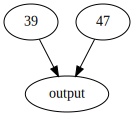

patching 24 edges, keeping 2 edges, 351 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9400, 0.9400, 0.9400, 0.9400, 0.9400, 0.9400, 0.9400, 0.9400, 0.9400,
        0.9400, 0.9400, 0.9400, 0.9400, 0.9500, 0.9400, 0.9400],
       device='cuda:0')
got scores tensor([0.9500, 0.9100, 0.9500, 0.9400, 0.9400, 0.9400, 0.9300, 0.9400, 0.9400,
        0.9400], device='cuda:0')
score for edge 0 -> 47 (blocks.0.hook_out_proj -> blocks.47.hook_layer_input) is 0.9399999976158142 baseline score is 0.9399999976158142 so difference is 0.0
patching edge 0 -> 47 (blocks.0.hook_out_proj -> blocks.47.hook_layer_input)
score for edge 8 -> 47 (blocks.8.hook_out_proj -> blocks.47.hook_layer_input) is 0.9399999976158142 baseline score is 0.9399999976158142 so difference is 0.0
patching edge 8 -> 47 (blocks.8.hook_out_proj -> blocks.47.hook_layer_input)
score for edge 9 -> 47 (blocks.9.hook_out_proj -> blocks.47.hook_layer_input) is 0.9399999976158142 baseline score is 0.9399999976158142 so difference is 0.0
patching edge 9 -> 47 (blocks.9.hook_out_proj -> blocks.47.hook_lay

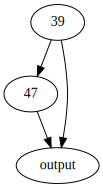

patching 49 edges, keeping 3 edges, 325 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600,
        0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
score for edge 0 -> 46 (blocks.0.hook_out_proj -> blocks.46.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 0 -> 46 (blocks.0.hook_out_proj -> blocks.46.hook_layer_input)
score for edge 8 -> 46 (blocks.8.hook_out_proj -> blocks.46.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 8 -> 46 (blocks.8.hook_out_proj -> blocks.46.hook_layer_input)
score for edge 9 -> 46 (blocks.9.hook_out_proj -> blocks.46.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 9 -> 46 (blocks.9.hook_out_proj -> blocks.46.hook_layer_input)

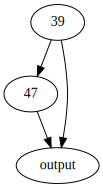

patching 74 edges, keeping 3 edges, 300 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600,
        0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
score for edge 0 -> 45 (blocks.0.hook_out_proj -> blocks.45.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 0 -> 45 (blocks.0.hook_out_proj -> blocks.45.hook_layer_input)
score for edge 8 -> 45 (blocks.8.hook_out_proj -> blocks.45.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 8 -> 45 (blocks.8.hook_out_proj -> blocks.45.hook_layer_input)
score for edge 9 -> 45 (blocks.9.hook_out_proj -> blocks.45.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 9 -> 45 (blocks.9.hook_out_proj -> blocks.45.hook_layer_input)
score f

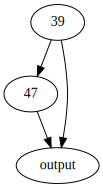

patching 98 edges, keeping 3 edges, 276 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600,
        0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
score for edge 0 -> 44 (blocks.0.hook_out_proj -> blocks.44.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 0 -> 44 (blocks.0.hook_out_proj -> blocks.44.hook_layer_input)
score for edge 8 -> 44 (blocks.8.hook_out_proj -> blocks.44.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 8 -> 44 (blocks.8.hook_out_proj -> blocks.44.hook_layer_input)
score for edge 9 -> 44 (blocks.9.hook_out_proj -> blocks.44.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 9 -> 44 (blocks.9.hook_out_proj -> blocks.44.hook_layer_input)
score for edge 

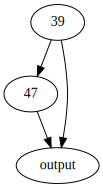

patching 121 edges, keeping 3 edges, 253 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600,
        0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600], device='cuda:0')
score for edge 0 -> 43 (blocks.0.hook_out_proj -> blocks.43.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 0 -> 43 (blocks.0.hook_out_proj -> blocks.43.hook_layer_input)
score for edge 8 -> 43 (blocks.8.hook_out_proj -> blocks.43.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 8 -> 43 (blocks.8.hook_out_proj -> blocks.43.hook_layer_input)
score for edge 9 -> 43 (blocks.9.hook_out_proj -> blocks.43.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 9 -> 43 (blocks.9.hook_out_proj -> blocks.43.hook_layer_input)
score for edge 11 -> 43 (block

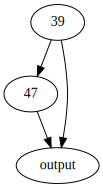

patching 143 edges, keeping 3 edges, 231 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600,
        0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600], device='cuda:0')
score for edge 0 -> 42 (blocks.0.hook_out_proj -> blocks.42.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 0 -> 42 (blocks.0.hook_out_proj -> blocks.42.hook_layer_input)
score for edge 8 -> 42 (blocks.8.hook_out_proj -> blocks.42.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 8 -> 42 (blocks.8.hook_out_proj -> blocks.42.hook_layer_input)
score for edge 9 -> 42 (blocks.9.hook_out_proj -> blocks.42.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 9 -> 42 (blocks.9.hook_out_proj -> blocks.42.hook_layer_input)
score for edge 11 -> 42 (blocks.11.hoo

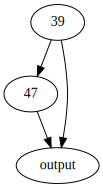

patching 164 edges, keeping 3 edges, 210 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600,
        0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
got scores tensor([0.9600, 0.9600, 0.9600, 0.9600], device='cuda:0')
score for edge 0 -> 41 (blocks.0.hook_out_proj -> blocks.41.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 0 -> 41 (blocks.0.hook_out_proj -> blocks.41.hook_layer_input)
score for edge 8 -> 41 (blocks.8.hook_out_proj -> blocks.41.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 8 -> 41 (blocks.8.hook_out_proj -> blocks.41.hook_layer_input)
score for edge 9 -> 41 (blocks.9.hook_out_proj -> blocks.41.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 9 -> 41 (blocks.9.hook_out_proj -> blocks.41.hook_layer_input)
score for edge 11 -> 41 (blocks.11.hook_out_pr

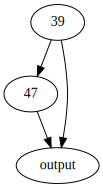

patching 184 edges, keeping 3 edges, 190 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600,
        0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600, 0.9600],
       device='cuda:0')
got scores tensor([0.9600, 0.9600, 0.9600], device='cuda:0')
score for edge 0 -> 40 (blocks.0.hook_out_proj -> blocks.40.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 0 -> 40 (blocks.0.hook_out_proj -> blocks.40.hook_layer_input)
score for edge 8 -> 40 (blocks.8.hook_out_proj -> blocks.40.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 8 -> 40 (blocks.8.hook_out_proj -> blocks.40.hook_layer_input)
score for edge 9 -> 40 (blocks.9.hook_out_proj -> blocks.40.hook_layer_input) is 0.9599999785423279 baseline score is 0.9599999785423279 so difference is 0.0
patching edge 9 -> 40 (blocks.9.hook_out_proj -> blocks.40.hook_layer_input)
score for edge 11 -> 40 (blocks.11.hook_out_proj -> bl

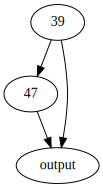

patching 203 edges, keeping 3 edges, 171 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.6100, 0.9500, 0.9500, 0.9400, 0.9400, 0.9400, 0.9400, 0.9300, 0.9200,
        0.9300, 0.9400, 0.9000, 0.9200, 0.9400, 0.9400, 0.9200],
       device='cuda:0')
got scores tensor([0.9100, 0.8900], device='cuda:0')
score for edge 0 -> 39 (blocks.0.hook_out_proj -> blocks.39.hook_layer_input) is 0.6100000143051147 baseline score is 0.9599999785423279 so difference is 0.34999996423721313
not patching edge 0 -> 39 (blocks.0.hook_out_proj -> blocks.39.hook_layer_input)
score for edge 8 -> 39 (blocks.8.hook_out_proj -> blocks.39.hook_layer_input) is 0.949999988079071 baseline score is 0.9599999785423279 so difference is 0.009999990463256836
patching edge 8 -> 39 (blocks.8.hook_out_proj -> blocks.39.hook_layer_input)
score for edge 9 -> 39 (blocks.9.hook_out_proj -> blocks.39.hook_layer_input) is 0.949999988079071 baseline score is 0.9599999785423279 so difference is 0.009999990463256836
patching edge 9 -> 39 (blocks.9.hook_out_proj -> blocks.39.hook_layer_input)
score for 

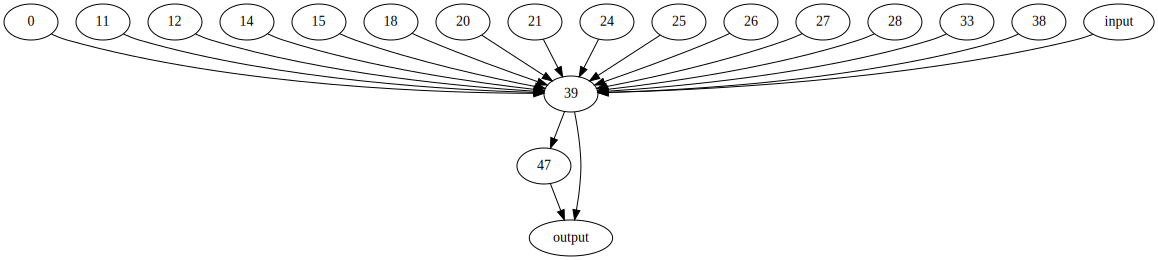

patching 205 edges, keeping 19 edges, 153 remain


  0%|          | 0/2 [00:00<?, ?it/s]

got scores tensor([0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9500, 0.9400, 0.9400, 0.9400,
        0.9500, 0.9400, 0.9200, 0.9300, 0.9400, 0.9200, 0.8900],
       device='cuda:0')
got scores tensor([0.9500], device='cuda:0')
score for edge 0 -> 38 (blocks.0.hook_out_proj -> blocks.38.hook_layer_input) is 0.949999988079071 baseline score is 0.949999988079071 so difference is 0.0
patching edge 0 -> 38 (blocks.0.hook_out_proj -> blocks.38.hook_layer_input)
score for edge 8 -> 38 (blocks.8.hook_out_proj -> blocks.38.hook_layer_input) is 0.949999988079071 baseline score is 0.949999988079071 so difference is 0.0
patching edge 8 -> 38 (blocks.8.hook_out_proj -> blocks.38.hook_layer_input)
score for edge 9 -> 38 (blocks.9.hook_out_proj -> blocks.38.hook_layer_input) is 0.949999988079071 baseline score is 0.949999988079071 so difference is 0.0
patching edge 9 -> 38 (blocks.9.hook_out_proj -> blocks.38.hook_layer_input)
score for edge 11 -> 38 (blocks.11.hook_out_proj -> blocks.38.hook_layer_inp

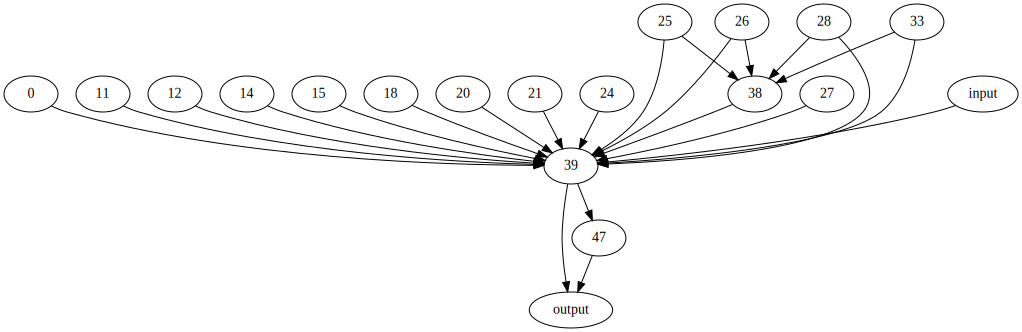

patching 218 edges, keeping 23 edges, 136 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.9400, 0.9400, 0.9400, 0.9400, 0.9400, 0.9300, 0.9500, 0.9400, 0.9400,
        0.9300, 0.9100, 0.9400, 0.9200, 0.9300, 0.9300, 0.9200],
       device='cuda:0')
score for edge 0 -> 33 (blocks.0.hook_out_proj -> blocks.33.hook_layer_input) is 0.9399999976158142 baseline score is 0.9399999976158142 so difference is 0.0
patching edge 0 -> 33 (blocks.0.hook_out_proj -> blocks.33.hook_layer_input)
score for edge 8 -> 33 (blocks.8.hook_out_proj -> blocks.33.hook_layer_input) is 0.9399999976158142 baseline score is 0.9399999976158142 so difference is 0.0
patching edge 8 -> 33 (blocks.8.hook_out_proj -> blocks.33.hook_layer_input)
score for edge 9 -> 33 (blocks.9.hook_out_proj -> blocks.33.hook_layer_input) is 0.9399999976158142 baseline score is 0.9399999976158142 so difference is 0.0
patching edge 9 -> 33 (blocks.9.hook_out_proj -> blocks.33.hook_layer_input)
score for edge 11 -> 33 (blocks.11.hook_out_proj -> blocks.33.hook_layer_input) is 0.9399999976158142 baseline scor

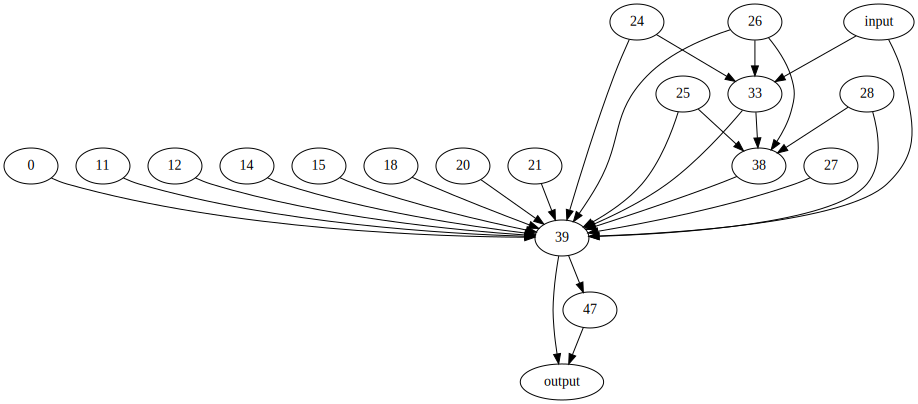

patching 231 edges, keeping 26 edges, 120 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.9100, 0.9200, 0.9200, 0.9200, 0.9100, 0.9100, 0.9100, 0.9100, 0.9100,
        0.9000, 0.9200, 0.9300, 0.8900, 0.9200, 0.9000], device='cuda:0')
score for edge 0 -> 28 (blocks.0.hook_out_proj -> blocks.28.hook_layer_input) is 0.9099999666213989 baseline score is 0.9199999570846558 so difference is 0.009999990463256836
patching edge 0 -> 28 (blocks.0.hook_out_proj -> blocks.28.hook_layer_input)
score for edge 8 -> 28 (blocks.8.hook_out_proj -> blocks.28.hook_layer_input) is 0.9199999570846558 baseline score is 0.9199999570846558 so difference is 0.0
patching edge 8 -> 28 (blocks.8.hook_out_proj -> blocks.28.hook_layer_input)
score for edge 9 -> 28 (blocks.9.hook_out_proj -> blocks.28.hook_layer_input) is 0.9199999570846558 baseline score is 0.9199999570846558 so difference is 0.0
patching edge 9 -> 28 (blocks.9.hook_out_proj -> blocks.28.hook_layer_input)
score for edge 11 -> 28 (blocks.11.hook_out_proj -> blocks.28.hook_layer_input) is 0.9199999570846558 baseline sc

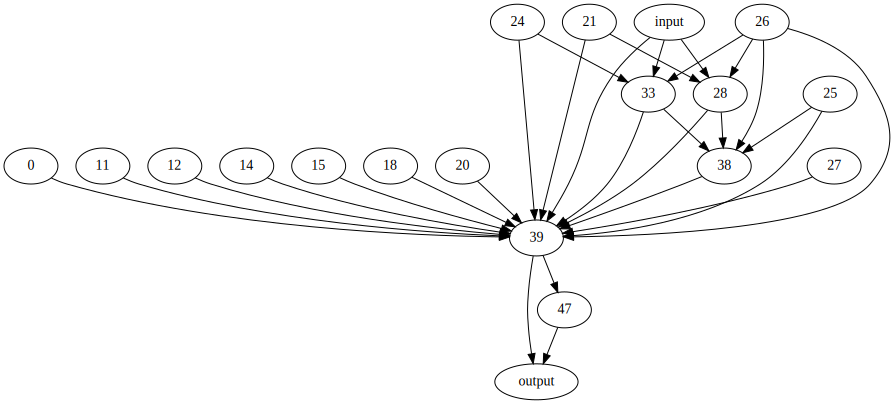

patching 243 edges, keeping 29 edges, 105 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.9100, 0.9100, 0.9100, 0.9200, 0.9100, 0.9200, 0.9100, 0.9100, 0.9100,
        0.9100, 0.9100, 0.9100, 0.8900, 0.9200], device='cuda:0')
score for edge 0 -> 27 (blocks.0.hook_out_proj -> blocks.27.hook_layer_input) is 0.9099999666213989 baseline score is 0.9099999666213989 so difference is 0.0
patching edge 0 -> 27 (blocks.0.hook_out_proj -> blocks.27.hook_layer_input)
score for edge 8 -> 27 (blocks.8.hook_out_proj -> blocks.27.hook_layer_input) is 0.9099999666213989 baseline score is 0.9099999666213989 so difference is 0.0
patching edge 8 -> 27 (blocks.8.hook_out_proj -> blocks.27.hook_layer_input)
score for edge 9 -> 27 (blocks.9.hook_out_proj -> blocks.27.hook_layer_input) is 0.9099999666213989 baseline score is 0.9099999666213989 so difference is 0.0
patching edge 9 -> 27 (blocks.9.hook_out_proj -> blocks.27.hook_layer_input)
score for edge 11 -> 27 (blocks.11.hook_out_proj -> blocks.27.hook_layer_input) is 0.9199999570846558 baseline score is 0.9099999666213989

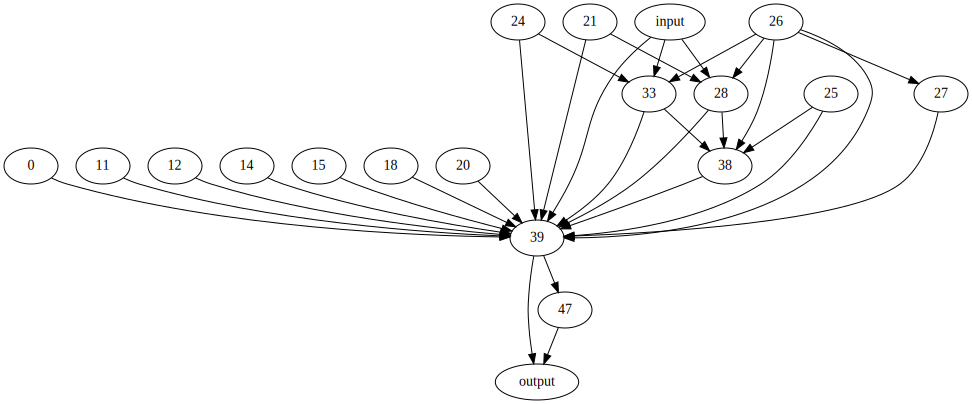

patching 256 edges, keeping 30 edges, 91 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.8900, 0.8900, 0.8900, 0.8900, 0.8700, 0.8700, 0.8900, 0.8900, 0.9000,
        0.8600, 0.8600, 0.8900, 0.8900], device='cuda:0')
score for edge 0 -> 26 (blocks.0.hook_out_proj -> blocks.26.hook_layer_input) is 0.8899999856948853 baseline score is 0.8899999856948853 so difference is 0.0
patching edge 0 -> 26 (blocks.0.hook_out_proj -> blocks.26.hook_layer_input)
score for edge 8 -> 26 (blocks.8.hook_out_proj -> blocks.26.hook_layer_input) is 0.8899999856948853 baseline score is 0.8899999856948853 so difference is 0.0
patching edge 8 -> 26 (blocks.8.hook_out_proj -> blocks.26.hook_layer_input)
score for edge 9 -> 26 (blocks.9.hook_out_proj -> blocks.26.hook_layer_input) is 0.8899999856948853 baseline score is 0.8899999856948853 so difference is 0.0
patching edge 9 -> 26 (blocks.9.hook_out_proj -> blocks.26.hook_layer_input)
score for edge 11 -> 26 (blocks.11.hook_out_proj -> blocks.26.hook_layer_input) is 0.8899999856948853 baseline score is 0.8899999856948853 so diff

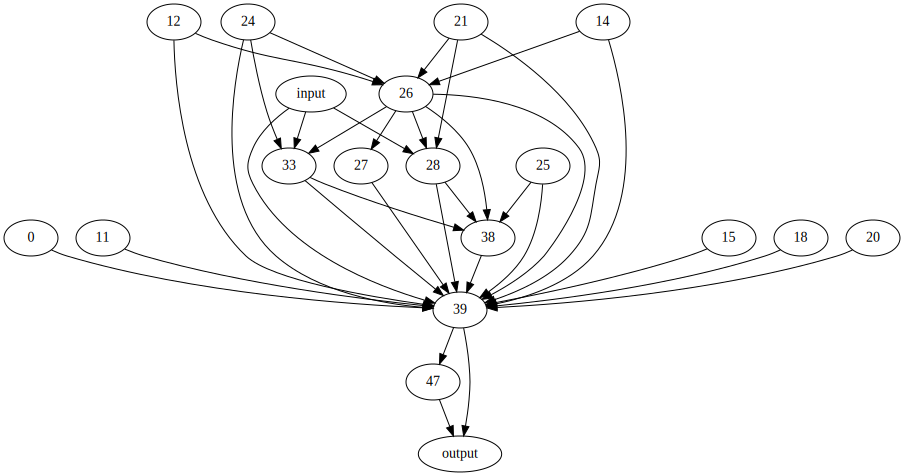

patching 265 edges, keeping 34 edges, 78 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.8600, 0.8700, 0.8700, 0.8600, 0.8700, 0.8700, 0.8700, 0.8700, 0.8600,
        0.8700, 0.8700, 0.8800], device='cuda:0')
score for edge 0 -> 25 (blocks.0.hook_out_proj -> blocks.25.hook_layer_input) is 0.85999995470047 baseline score is 0.8700000047683716 so difference is 0.010000050067901611
not patching edge 0 -> 25 (blocks.0.hook_out_proj -> blocks.25.hook_layer_input)
score for edge 8 -> 25 (blocks.8.hook_out_proj -> blocks.25.hook_layer_input) is 0.8700000047683716 baseline score is 0.8700000047683716 so difference is 0.0
patching edge 8 -> 25 (blocks.8.hook_out_proj -> blocks.25.hook_layer_input)
score for edge 9 -> 25 (blocks.9.hook_out_proj -> blocks.25.hook_layer_input) is 0.8700000047683716 baseline score is 0.8700000047683716 so difference is 0.0
patching edge 9 -> 25 (blocks.9.hook_out_proj -> blocks.25.hook_layer_input)
score for edge 11 -> 25 (blocks.11.hook_out_proj -> blocks.25.hook_layer_input) is 0.85999995470047 baseline score is 0.870000004768371

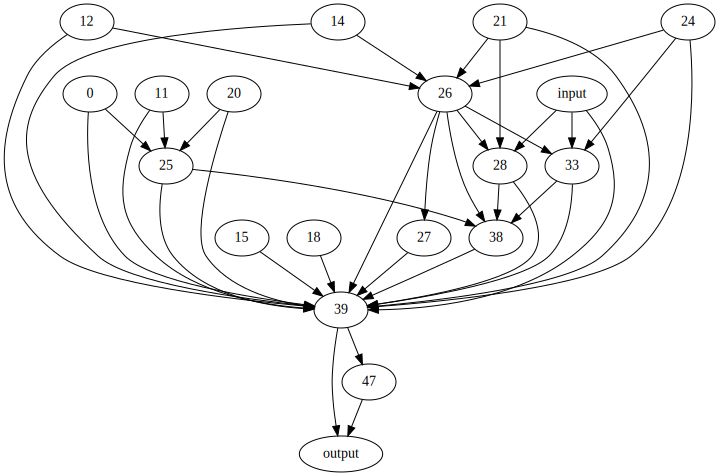

patching 274 edges, keeping 37 edges, 66 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.8500, 0.8500, 0.8500, 0.8500, 0.8500, 0.8600, 0.8500, 0.8500, 0.8700,
        0.8700, 0.8600], device='cuda:0')
score for edge 0 -> 24 (blocks.0.hook_out_proj -> blocks.24.hook_layer_input) is 0.8499999642372131 baseline score is 0.85999995470047 so difference is 0.009999990463256836
patching edge 0 -> 24 (blocks.0.hook_out_proj -> blocks.24.hook_layer_input)
score for edge 8 -> 24 (blocks.8.hook_out_proj -> blocks.24.hook_layer_input) is 0.8499999642372131 baseline score is 0.85999995470047 so difference is 0.009999990463256836
patching edge 8 -> 24 (blocks.8.hook_out_proj -> blocks.24.hook_layer_input)
score for edge 9 -> 24 (blocks.9.hook_out_proj -> blocks.24.hook_layer_input) is 0.8499999642372131 baseline score is 0.85999995470047 so difference is 0.009999990463256836
patching edge 9 -> 24 (blocks.9.hook_out_proj -> blocks.24.hook_layer_input)
score for edge 11 -> 24 (blocks.11.hook_out_proj -> blocks.24.hook_layer_input) is 0.8499999642372131 baseline score 

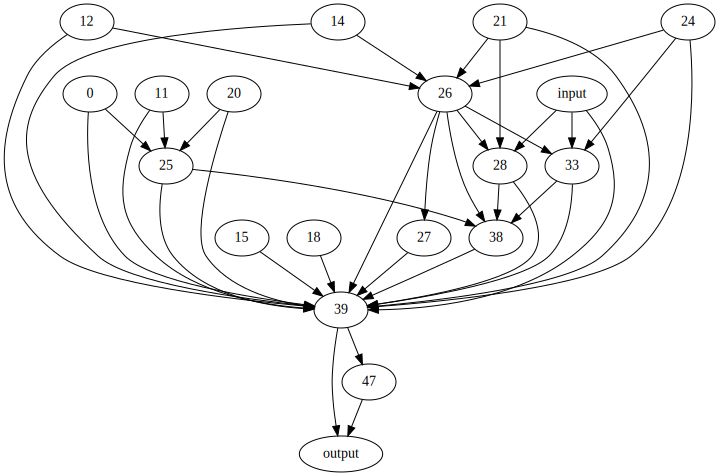

patching 285 edges, keeping 37 edges, 55 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.8300, 0.8400, 0.8400, 0.8500, 0.8300, 0.8400, 0.8500, 0.8400, 0.8100,
        0.8400], device='cuda:0')
score for edge 0 -> 21 (blocks.0.hook_out_proj -> blocks.21.hook_layer_input) is 0.8299999833106995 baseline score is 0.8399999737739563 so difference is 0.009999990463256836
patching edge 0 -> 21 (blocks.0.hook_out_proj -> blocks.21.hook_layer_input)
score for edge 8 -> 21 (blocks.8.hook_out_proj -> blocks.21.hook_layer_input) is 0.8399999737739563 baseline score is 0.8399999737739563 so difference is 0.0
patching edge 8 -> 21 (blocks.8.hook_out_proj -> blocks.21.hook_layer_input)
score for edge 9 -> 21 (blocks.9.hook_out_proj -> blocks.21.hook_layer_input) is 0.8399999737739563 baseline score is 0.8399999737739563 so difference is 0.0
patching edge 9 -> 21 (blocks.9.hook_out_proj -> blocks.21.hook_layer_input)
score for edge 11 -> 21 (blocks.11.hook_out_proj -> blocks.21.hook_layer_input) is 0.8499999642372131 baseline score is 0.8399999737739563 so difference 

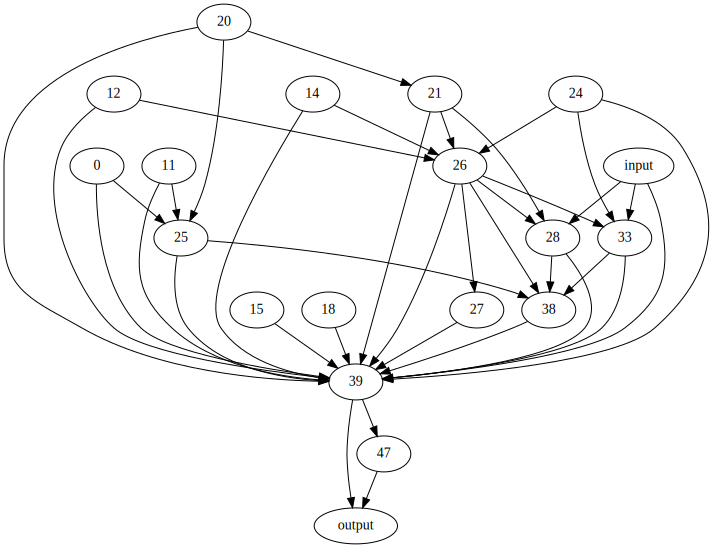

patching 294 edges, keeping 38 edges, 45 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.8000, 0.8200, 0.8100, 0.8100, 0.8300, 0.8100, 0.8200, 0.8300, 0.7900],
       device='cuda:0')
score for edge 0 -> 20 (blocks.0.hook_out_proj -> blocks.20.hook_layer_input) is 0.7999999523162842 baseline score is 0.8199999928474426 so difference is 0.020000040531158447
not patching edge 0 -> 20 (blocks.0.hook_out_proj -> blocks.20.hook_layer_input)
score for edge 8 -> 20 (blocks.8.hook_out_proj -> blocks.20.hook_layer_input) is 0.8199999928474426 baseline score is 0.8199999928474426 so difference is 0.0
patching edge 8 -> 20 (blocks.8.hook_out_proj -> blocks.20.hook_layer_input)
score for edge 9 -> 20 (blocks.9.hook_out_proj -> blocks.20.hook_layer_input) is 0.8100000023841858 baseline score is 0.8199999928474426 so difference is 0.009999990463256836
patching edge 9 -> 20 (blocks.9.hook_out_proj -> blocks.20.hook_layer_input)
score for edge 11 -> 20 (blocks.11.hook_out_proj -> blocks.20.hook_layer_input) is 0.8100000023841858 baseline score is 0.8199999928474426 so

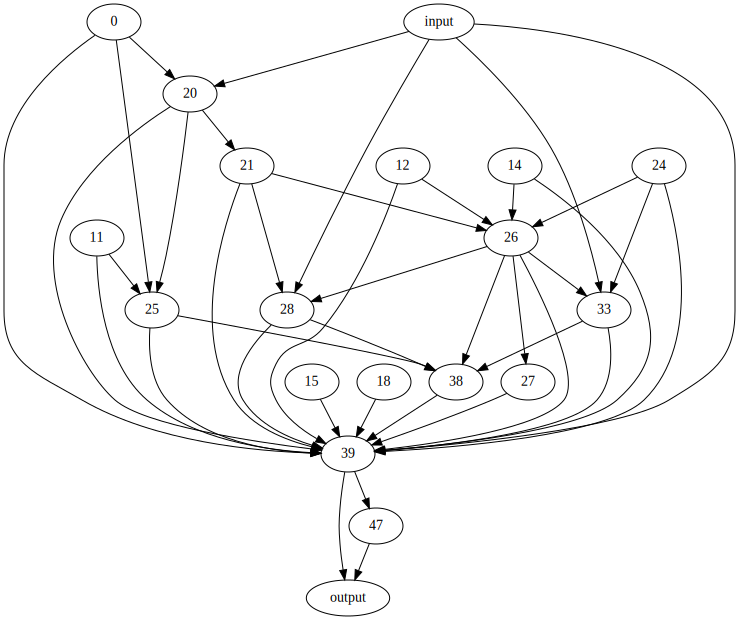

patching 301 edges, keeping 40 edges, 36 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.8000, 0.8100, 0.8200, 0.8100, 0.8000, 0.8000, 0.7900, 0.7900],
       device='cuda:0')
score for edge 0 -> 18 (blocks.0.hook_out_proj -> blocks.18.hook_layer_input) is 0.7999999523162842 baseline score is 0.8100000023841858 so difference is 0.010000050067901611
not patching edge 0 -> 18 (blocks.0.hook_out_proj -> blocks.18.hook_layer_input)
score for edge 8 -> 18 (blocks.8.hook_out_proj -> blocks.18.hook_layer_input) is 0.8100000023841858 baseline score is 0.8100000023841858 so difference is 0.0
patching edge 8 -> 18 (blocks.8.hook_out_proj -> blocks.18.hook_layer_input)
score for edge 9 -> 18 (blocks.9.hook_out_proj -> blocks.18.hook_layer_input) is 0.8199999928474426 baseline score is 0.8100000023841858 so difference is -0.009999990463256836
patching edge 9 -> 18 (blocks.9.hook_out_proj -> blocks.18.hook_layer_input)
score for edge 11 -> 18 (blocks.11.hook_out_proj -> blocks.18.hook_layer_input) is 0.8100000023841858 baseline score is 0.8100000023841858 so differ

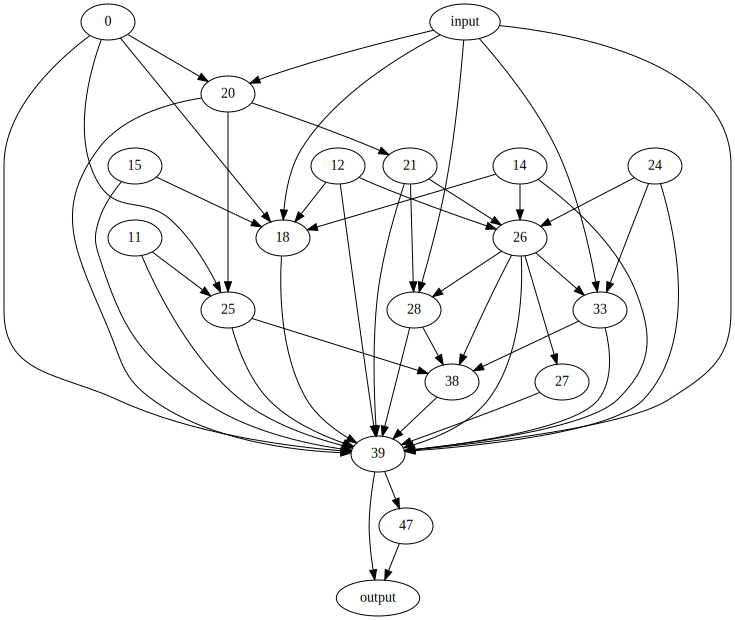

patching 304 edges, keeping 45 edges, 28 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.7700, 0.8100, 0.8100, 0.8000, 0.8000, 0.8000, 0.8100],
       device='cuda:0')
score for edge 0 -> 15 (blocks.0.hook_out_proj -> blocks.15.hook_layer_input) is 0.7699999809265137 baseline score is 0.8100000023841858 so difference is 0.04000002145767212
not patching edge 0 -> 15 (blocks.0.hook_out_proj -> blocks.15.hook_layer_input)
score for edge 8 -> 15 (blocks.8.hook_out_proj -> blocks.15.hook_layer_input) is 0.8100000023841858 baseline score is 0.8100000023841858 so difference is 0.0
patching edge 8 -> 15 (blocks.8.hook_out_proj -> blocks.15.hook_layer_input)
score for edge 9 -> 15 (blocks.9.hook_out_proj -> blocks.15.hook_layer_input) is 0.8100000023841858 baseline score is 0.8100000023841858 so difference is 0.0
patching edge 9 -> 15 (blocks.9.hook_out_proj -> blocks.15.hook_layer_input)
score for edge 11 -> 15 (blocks.11.hook_out_proj -> blocks.15.hook_layer_input) is 0.7999999523162842 baseline score is 0.8100000023841858 so difference is 0.01000005006790161

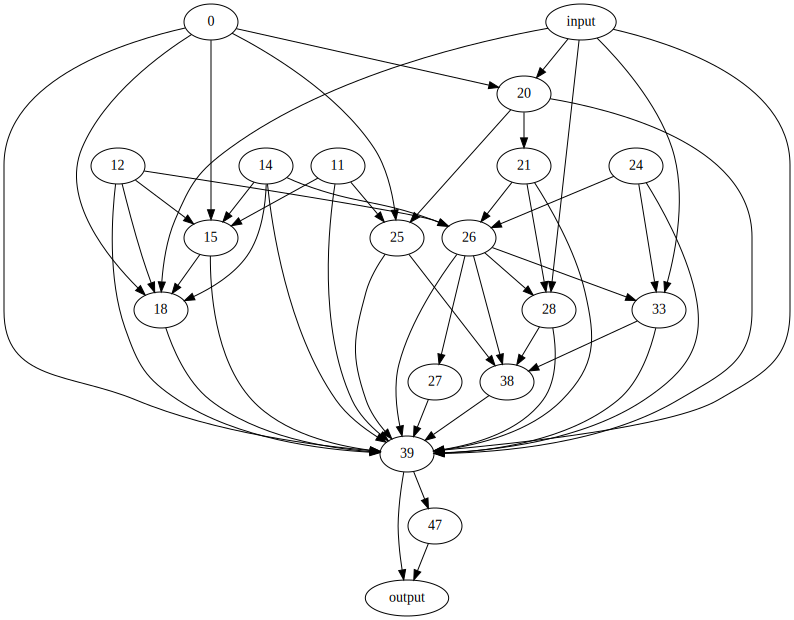

patching 307 edges, keeping 49 edges, 21 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.7900, 0.8000, 0.8100, 0.8300, 0.8000, 0.8100], device='cuda:0')
score for edge 0 -> 14 (blocks.0.hook_out_proj -> blocks.14.hook_layer_input) is 0.7899999618530273 baseline score is 0.7999999523162842 so difference is 0.009999990463256836
patching edge 0 -> 14 (blocks.0.hook_out_proj -> blocks.14.hook_layer_input)
score for edge 8 -> 14 (blocks.8.hook_out_proj -> blocks.14.hook_layer_input) is 0.7999999523162842 baseline score is 0.7999999523162842 so difference is 0.0
patching edge 8 -> 14 (blocks.8.hook_out_proj -> blocks.14.hook_layer_input)
score for edge 9 -> 14 (blocks.9.hook_out_proj -> blocks.14.hook_layer_input) is 0.8100000023841858 baseline score is 0.7999999523162842 so difference is -0.010000050067901611
patching edge 9 -> 14 (blocks.9.hook_out_proj -> blocks.14.hook_layer_input)
score for edge 11 -> 14 (blocks.11.hook_out_proj -> blocks.14.hook_layer_input) is 0.8299999833106995 baseline score is 0.7999999523162842 so difference is -0.0300000309944152

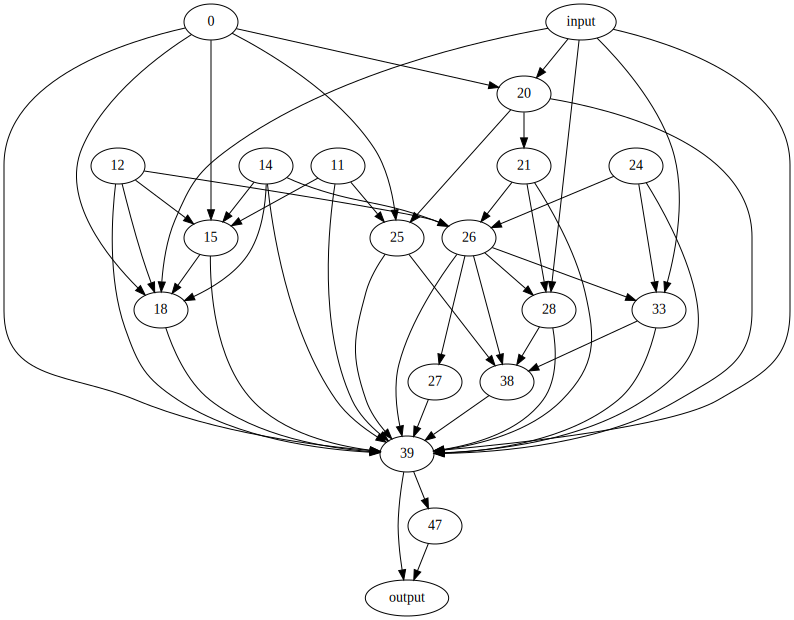

patching 313 edges, keeping 49 edges, 15 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.7400, 0.7700, 0.7600, 0.7800, 0.7400], device='cuda:0')
score for edge 0 -> 12 (blocks.0.hook_out_proj -> blocks.12.hook_layer_input) is 0.7400000095367432 baseline score is 0.7699999809265137 so difference is 0.029999971389770508
not patching edge 0 -> 12 (blocks.0.hook_out_proj -> blocks.12.hook_layer_input)
score for edge 8 -> 12 (blocks.8.hook_out_proj -> blocks.12.hook_layer_input) is 0.7699999809265137 baseline score is 0.7699999809265137 so difference is 0.0
patching edge 8 -> 12 (blocks.8.hook_out_proj -> blocks.12.hook_layer_input)
score for edge 9 -> 12 (blocks.9.hook_out_proj -> blocks.12.hook_layer_input) is 0.7599999904632568 baseline score is 0.7699999809265137 so difference is 0.009999990463256836
patching edge 9 -> 12 (blocks.9.hook_out_proj -> blocks.12.hook_layer_input)
score for edge 11 -> 12 (blocks.11.hook_out_proj -> blocks.12.hook_layer_input) is 0.7799999713897705 baseline score is 0.7699999809265137 so difference is -0.009999990463256836
pa

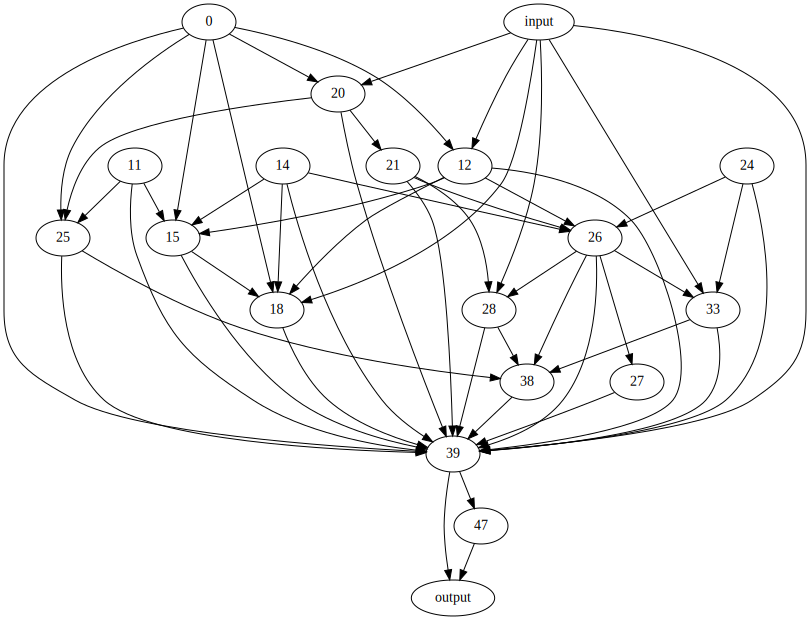

patching 316 edges, keeping 51 edges, 10 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.7500, 0.7700, 0.7600, 0.7500], device='cuda:0')
score for edge 0 -> 11 (blocks.0.hook_out_proj -> blocks.11.hook_layer_input) is 0.75 baseline score is 0.7599999904632568 so difference is 0.009999990463256836
patching edge 0 -> 11 (blocks.0.hook_out_proj -> blocks.11.hook_layer_input)
score for edge 8 -> 11 (blocks.8.hook_out_proj -> blocks.11.hook_layer_input) is 0.7699999809265137 baseline score is 0.7599999904632568 so difference is -0.009999990463256836
patching edge 8 -> 11 (blocks.8.hook_out_proj -> blocks.11.hook_layer_input)
score for edge 9 -> 11 (blocks.9.hook_out_proj -> blocks.11.hook_layer_input) is 0.7599999904632568 baseline score is 0.7599999904632568 so difference is 0.0
patching edge 9 -> 11 (blocks.9.hook_out_proj -> blocks.11.hook_layer_input)
score for edge input -> 11 (hook_embed -> blocks.11.hook_layer_input) is 0.75 baseline score is 0.7599999904632568 so difference is 0.009999990463256836
patching edge input -> 11 (hook_embed -> blocks.11.h

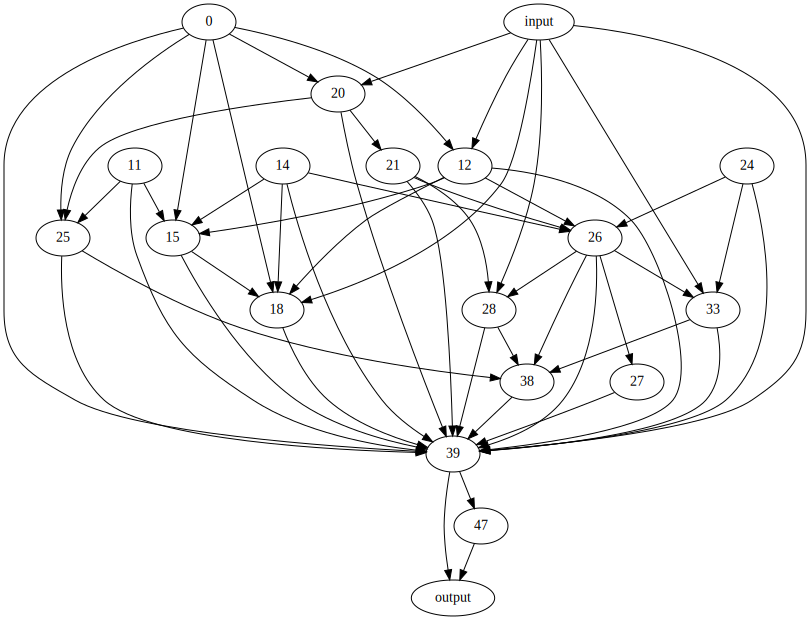

patching 320 edges, keeping 51 edges, 6 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.7300, 0.7300, 0.7300], device='cuda:0')
score for edge 0 -> 9 (blocks.0.hook_out_proj -> blocks.9.hook_layer_input) is 0.7299999594688416 baseline score is 0.7299999594688416 so difference is 0.0
patching edge 0 -> 9 (blocks.0.hook_out_proj -> blocks.9.hook_layer_input)
score for edge 8 -> 9 (blocks.8.hook_out_proj -> blocks.9.hook_layer_input) is 0.7299999594688416 baseline score is 0.7299999594688416 so difference is 0.0
patching edge 8 -> 9 (blocks.8.hook_out_proj -> blocks.9.hook_layer_input)
score for edge input -> 9 (hook_embed -> blocks.9.hook_layer_input) is 0.7299999594688416 baseline score is 0.7299999594688416 so difference is 0.0
patching edge input -> 9 (hook_embed -> blocks.9.hook_layer_input)


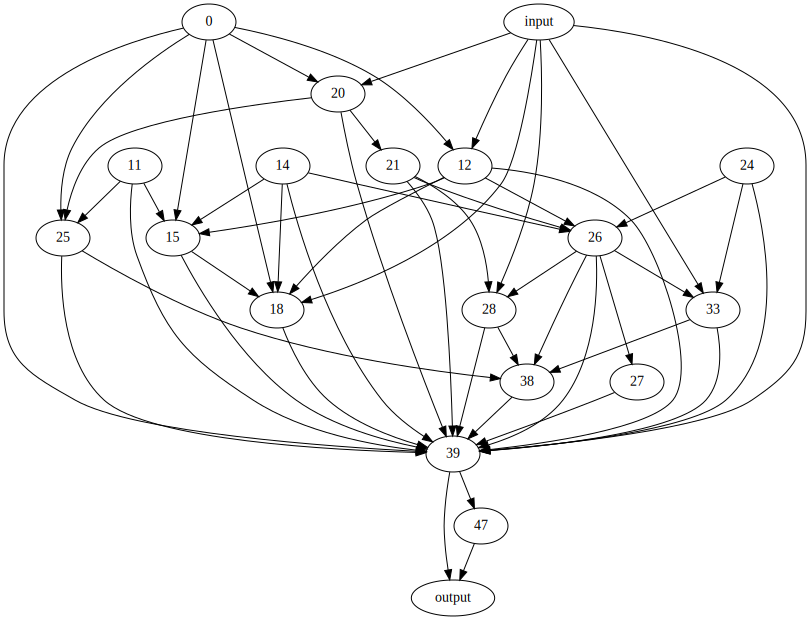

patching 323 edges, keeping 51 edges, 3 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.7300, 0.7300], device='cuda:0')
score for edge 0 -> 8 (blocks.0.hook_out_proj -> blocks.8.hook_layer_input) is 0.7299999594688416 baseline score is 0.7299999594688416 so difference is 0.0
patching edge 0 -> 8 (blocks.0.hook_out_proj -> blocks.8.hook_layer_input)
score for edge input -> 8 (hook_embed -> blocks.8.hook_layer_input) is 0.7299999594688416 baseline score is 0.7299999594688416 so difference is 0.0
patching edge input -> 8 (hook_embed -> blocks.8.hook_layer_input)


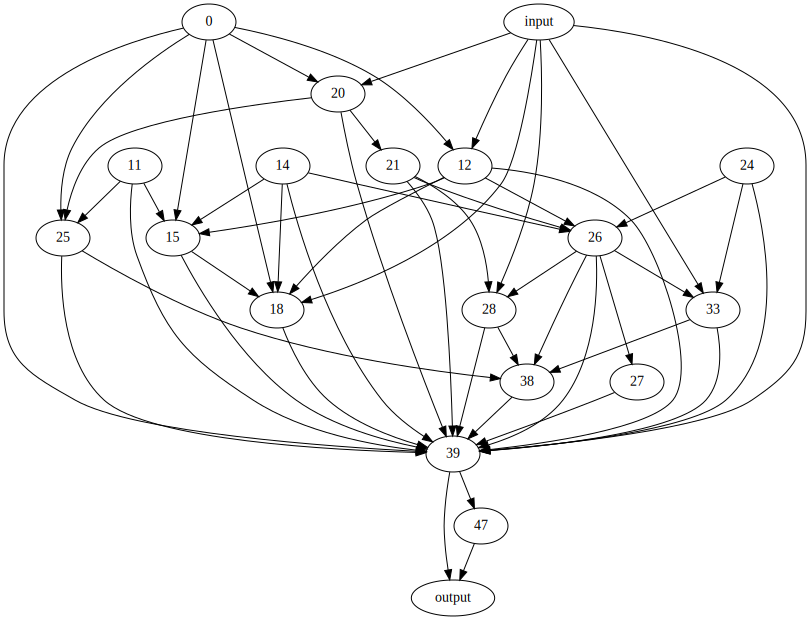

patching 325 edges, keeping 51 edges, 1 remain


  0%|          | 0/1 [00:00<?, ?it/s]

got scores tensor([0.0300], device='cuda:0')
score for edge input -> 0 (hook_embed -> blocks.0.hook_layer_input) is 0.029999999329447746 baseline score is 0.7299999594688416 so difference is 0.699999988079071
not patching edge input -> 0 (hook_embed -> blocks.0.hook_layer_input)


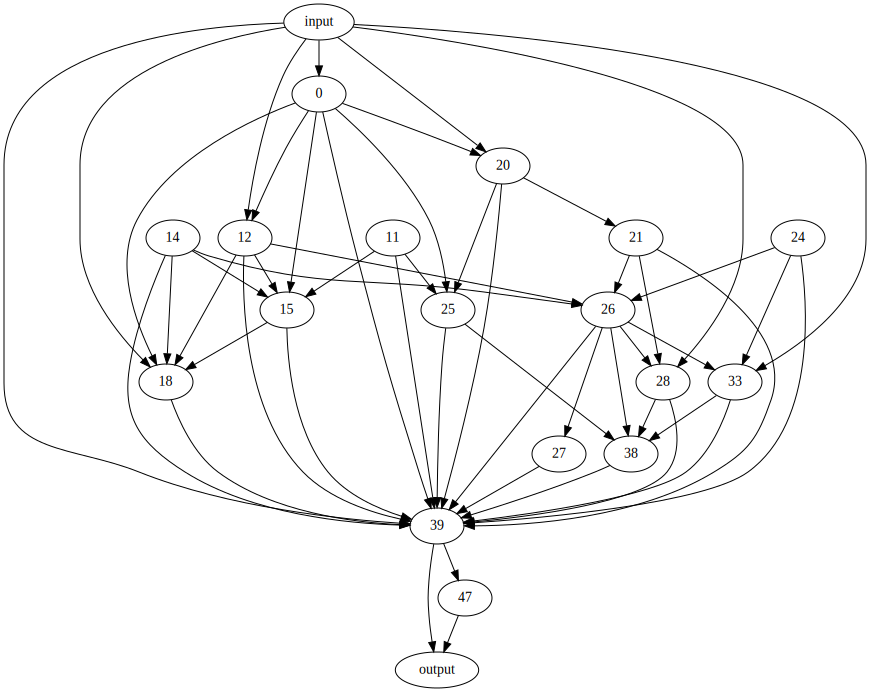

pruning node 11 because it doesn't have a path from input -> 11 -> output
pruning node 14 because it doesn't have a path from input -> 14 -> output
pruning node 24 because it doesn't have a path from input -> 24 -> output
final output:


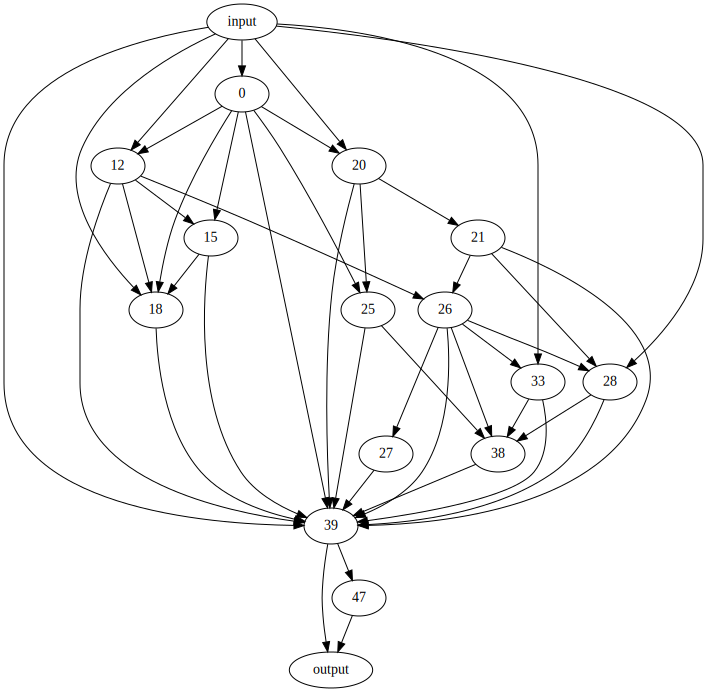

In [42]:
import copy
# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
model.remove_all_hook_fns()

# because every pair (i,i+1) is a patching (uncorrupted, corrupted),
# we want things to be symmetric,
# so we will double up our dataset
# by swapping each pair
def repeat_swapped_patch(vec):
    swapped_vecs = []
    for i in range(0, vec.size()[0], 2):
        swapped_vecs += [vec[i+1:i+2], vec[i:i+1]]
    return torch.cat([vec] + swapped_vecs, dim=0)

def eval_acdc(model, data, correct, incorrect, metric, num_edges, constrain_to_answers, **kwargs):
    num_examples = correct.size()[0]
    
    logits = model(data, **kwargs)[:,-1]

    # they come in pairs, uncorrupted, corrupted
    # we patch the first one in the pair, so only measure accuracy on that
    patched_logits = logits[::2]
    corrupted_logits = logits[1::2]
    patched_correct = correct[::2]
    patched_incorect = incorrect[::2]
    
    pad = get_pad_token(tokenizer=model.tokenizer)
    logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect
        
    n_data, n_correct = patched_correct.size()
    n_data, n_incorrect = patched_incorect.size()
    
    # [n_data, n_correct]
    correct_logits = index_into(patched_logits, patched_correct)
    # [n_data, n_incorrect]
    incorrect_logits = index_into(patched_logits, patched_incorect)
    
    if constrain_to_answers:
        # [n_data, n_correct + n_incorrect]
        combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
        combined_prs = torch.softmax(combined_logits, dim=1)
        biggest = torch.argsort(-combined_prs, dim=1)
        # if biggest pr is in the correct, we are correct, otherwise, we are not
        has_correct = biggest[:,0] < n_correct

        correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
    else:
        prs = torch.nn.functional.softmax(patched_logits, dim=1)
        # [n_data, n_correct]
        correct_prs = index_into(prs, patched_corect)
        # [n_data, n_incorrect]
        incorrect_prs = index_into(prs, patched_incorect)
        # [n_data, 1]
        top_tokens = torch.topk(patched_logits, 1, dim=1).indices
        # [n_data, n_correct]
        is_correct = top_tokens == patched_corect
        # [n_data]
        has_correct = torch.any(is_correct, dim=1)

    metric_results = torch.zeros([num_edges], device=device)
    batch_size = n_data//num_edges
    for i, batch_start in enumerate(range(0, n_data, batch_size)):
        batch_end = batch_start + batch_size
        metric_results[i] = metric(
            patched_logits=patched_logits[batch_start:batch_end],
            corrupted_logits=corrupted_logits[batch_start:batch_end],
            correct_logits=correct_logits[batch_start:batch_end],
            incorrect_logits=incorrect_logits[batch_start:batch_end],
            correct_prs=correct_prs[batch_start:batch_end],
            incorrect_prs=incorrect_prs[batch_start:batch_end],
            top_is_correct=has_correct[batch_start:batch_end],
        )
    return metric_results

def accuracy_metric(
    patched_logits,
    corrupted_logits,
    correct_logits,
    incorrect_logits,
    correct_prs,
    incorrect_prs,
    top_is_correct):
    return torch.sum(top_is_correct)/top_is_correct.size()[0]

# we want the subnetwork that "uses" the information we patch away
# thus we start with the last layer
#   find the positions that, when we patch there, normalized logit diff is above a threshold
#     we could either:
#       run every one seperately and pick those that are past a thresh
#         misses redundant circuits that only show up when you run both
#       test every pair of positions, and pick those that are past a thresh
#         expensive and probably over-fires:
#            if A is uses, then all A->B will also fire
#                this can be addressed by seeing if B increases it at all?
#                But if they are both dependencies then removing either should just kill the circuit
#       realistically, there are no i,j dependencies within a specific layer (probably?) so it's safe to start
#         with just grabbing everything past a thresh
#    okay so that gives us one layer
#      now we want to add more nodes to our graph
#      maybe a good start is just getting all the nodes, we can worry about connections later


# there's the edge trick
# where if we have A->C->E (and also some indirect path A->B->C, and some other A->D->E)
# then we want to ablate away the A->C edge
# we do this by running everything like we would with no patching,
# except that C receives inputs from A as if it was patched
# (however, B still receives inputs from A as if it was not patched, this is "trying to piece out the direct connection without other variable B")

# that's the idea, how do we implement it?
# each term adds stuff to the residual stream
# call 
# a_uncorrupted = output of A (no patching) to the residual stream
# a_corrupted = output of A (with patching) to the residual stream
# and call
# c_input = residual stream input to C (with no patching)
# we can just do
# c_input = c_input - a_uncorrupted + a_corrupted
# because everything adds to the residual stream this just makes sense

# simple version:
# 1. Find the layers that, when we patch, light up
# 2. For each layer from 1, find the components that, when we patch, light up
# 3. For each component from 2, find the positions that, when we patch, light up
#            but different patchings have different positions?
#              probably we want steps 1 and 2 to run over all patchings, but step 3 to output per each patching
#                    might also just be useful to run this seperately for each patching tbh
# 
# more complex version:
# 1. Start with last layer:
#        for each edge (other layer -> last layer), try patching
#            build a graph with that

# edge subnetwork probing better than edge acdc also see Attribution Patching Outperforms Automated Circuit Discovery (EAC)

THRESH = 0.01
BATCH_SIZE = 16 # how many multiples of the dataset to process at the same time
limited_layers = [0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

pbatched_data = repeat_swapped_patch(batched_data)
pbatched_correct = repeat_swapped_patch(batched_correct)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect)
vpbatched_data = repeat_swapped_patch(vbatched_data)
vpbatched_correct = repeat_swapped_patch(vbatched_correct)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect)
data_size = pbatched_data.size()[0]

# there are edges from:
# hook_embed -> every layer hook_layer_input
# every layer hook_out_proj -> every (later) layer hook_layer_input
# hook_embed and every layer hook_out_proj -> resid_post of final layer

# maybe it is less principled, but i think it could prune less edges if it pruned in a different order
# right now it prunes until it hits thresh and then straddles it, and random variations leave the rest to either be thrown out or not



edge_hook_names = []
last_layer = max(limited_layers)

INPUT_HOOK = f'hook_embed'
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'

INPUT_NODE = 'input'
OUTPUT_NODE = 'output'

## Setup edges for ACDC
for i in limited_layers:
    edge_hook_names.append((INPUT_HOOK, f"blocks.{i}.hook_layer_input"))
    for j in limited_layers:
            if i < j:
                edge_hook_names.append((f"blocks.{i}.hook_out_proj", f"blocks.{j}.hook_layer_input"))
    # the resid post on the last layer is simply the output resid of the entire model
    edge_hook_names.append((f"blocks.{i}.hook_out_proj", OUTPUT_HOOK))

## Setup nodes for ACDC
nodes = {}
nodes[INPUT_NODE] = [INPUT_HOOK]
for i in limited_layers:
    nodes[str(i)] = [f"blocks.{i}.hook_layer_input", f"blocks.{i}.hook_out_proj"]
nodes[OUTPUT_NODE] = [OUTPUT_HOOK]


global storage
storage = {}
def edge_input_storage_hook(
    x,
    hook: HookPoint,
):
    global storage
    storage[hook.name] = x
    return x

def edge_output_patching_hook(
    x,
    hook: HookPoint,
    input_hook: str,
    batch_start: int,
    batch_end: int
):
    global storage
    x_uncorrupted = storage[input_hook][batch_start:batch_end:2]
    x_corrupted = storage[input_hook][batch_start+1:batch_end+1:2]
    x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    return x

@dataclass
class Edge:
    input_hook: str
    output_hook: str
    input_node: str
    output_node: str
    patching: bool = False
    checked: bool = False

    def get_hooks(self, batch_start, batch_end):
        input_storage_hook = (self.input_hook, edge_input_storage_hook)
        output_patching_hook = (self.output_hook, partial(edge_output_patching_hook,
                                                          input_hook=self.input_hook,
                                                          batch_start=batch_start,
                                                          batch_end=batch_end))
        return [input_storage_hook, output_patching_hook]

    def __str__(self):
        return f"{self.input_node} -> {self.output_node} ({self.input_hook} -> {self.output_hook})"

@dataclass
class Node:
    name: str
    incoming_edges: List[Edge] = field(default_factory=lambda: [])
    outgoing_edges: list[Edge] = field(default_factory=lambda: [])

# make a lookup from hook to node name 
hook_to_node_name = {}
for node_name, node_hooks in nodes.items():
    for hook in node_hooks:
        hook_to_node_name[hook] = node_name
for input_hook, output_hook in edge_hook_names:
    if not input_hook in hook_to_node_name:
        raise ValueError(f"hook {input_hook} does not have a corresponding node")
    if not output_hook in hook_to_node_name:
        raise ValueError(f"hook {output_hook} does not have a corresponding node")

# make all the edges
all_node_names = set()
edges = []
for (input_hook, output_hook) in edge_hook_names:
    input_node, output_node = hook_to_node_name[input_hook], hook_to_node_name[output_hook]
    edges.append(Edge(input_hook=input_hook, output_hook=output_hook, input_node=input_node, output_node=output_node))
    all_node_names.add(input_node)
    all_node_names.add(output_node)

# construct the graph
all_nodes = dict([(name, Node(name=name)) for name in sorted(list(all_node_names))])
for edge in edges:
    all_nodes[edge.input_node].outgoing_edges.append(edge)
    all_nodes[edge.output_node].incoming_edges.append(edge)


# returns edges that should be considered next for pruning by acdc
def get_edges_to_check(nodes):
    for node_name, node in sorted(list(all_nodes.items())):
        # if we have checked all our outgoing edges (or we have none), we are safe to expand incoming edges
        all_outgoing_checked = all([outgoing_edge.checked for outgoing_edge in node.outgoing_edges])
        if all_outgoing_checked:
            for edge in node.incoming_edges:
                if not edge.checked:
                    yield edge

# restore from backup, if u want
'''
with open("backup_items_79.pkl", "rb") as f:
    [backup_edges, backup_nodes] = cloudpickle.load(f)
    for edge in backup_edges:
        current_edge = None
        for other_edge in edges:
            if other_edge.input_hook == edge.input_hook and other_edge.output_hook == edge.output_hook:
                current_edge = other_edge
                break
        if current_edge is None:
            print("could not find edge", edge)
        else:                
            # carry over anything that is patching
            if edge.patching:
                current_edge.patching = True
                current_edge.checked = True
'''            

def get_nx_graph(edges):
    G = nx.DiGraph()
    labeldict = defaultdict(lambda: set())
    for edge in edges:
        if edge.checked and not edge.patching:
            G.add_edge(edge.input_node, edge.output_node)
    return G

def draw_nx_graph(nodes, edges):
    import matplotlib.pyplot as plt
    import networkx as nx
    G = get_nx_graph(edges=edges)
    nx.draw_networkx(G, with_labels=True, font_size=8)
    plt.show()

def get_graphviz_graph(edges):
    import graphviz
    dot = graphviz.Digraph('result')
    for edge in edges:
        if edge.checked and not edge.patching:
            dot.edge(edge.input_node, edge.output_node)
    return dot

def draw_graphviz_graph(edges):
    from IPython.display import display
    display(get_graphviz_graph(edges=edges))


iters = 0
while len(list(get_edges_to_check(nodes=all_nodes))) > 0:

    # get edges that are next to check (because they don't have any edges after them that haven't been checked)
    edges_to_check = list(get_edges_to_check(nodes=all_nodes))
    
    # get hooks for currently patched edges
    currently_patched_edge_hooks = []
    num_patching, num_keeping = 0, 0
    # get hooks of all patched hooks
    for edge in edges:
        if edge.patching:
            currently_patched_edge_hooks += edge.get_hooks(batch_start=0, batch_end=len(edges_to_check)*data_size) # if it's too big it'll just grab everything which is what we want
            num_patching += 1
        elif edge.checked:
            num_keeping += 1
    print(f"patching {num_patching} edges, keeping {num_keeping} edges, {len(edges)-num_patching-num_keeping} remain")

    # get baseline metric
    baseline_score = eval_acdc(
        model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, only_use_these_layers=limited_layers),
        data=pbatched_data,
        correct=pbatched_correct,
        incorrect=pbatched_incorrect,
        metric=accuracy_metric,
        num_edges=1,
        constrain_to_answers=constrain_to_answers)[0].item()

    out_scores = torch.zeros([len(edges_to_check)])
    for batch_start in tqdm(list(range(0, len(edges_to_check), BATCH_SIZE))):
        # clean up 
        global storage
        for k in list(storage.keys()):
            del storage[k]
        torch.cuda.empty_cache()
        
        batch_end = min(batch_start+BATCH_SIZE, len(edges_to_check))
        batch_size = batch_end-batch_start
        
        # stack data for each edge
        def stack_data_for_each_edge(data, n_edges):
            return torch.cat([data]*n_edges, dim=0)
        
        pbatched_data_edges = stack_data_for_each_edge(pbatched_data, n_edges=batch_size)
        pbatched_correct_edges = stack_data_for_each_edge(pbatched_correct, n_edges=batch_size)
        pbatched_incorrect_edges = stack_data_for_each_edge(pbatched_incorrect, n_edges=batch_size)
    
        stacked_data_size = pbatched_data_edges.size()[0]

        batch_edges = edges_to_check[batch_start:batch_end]
        
        # add hooks for new edges we are testing
        hooks = copy.copy(currently_patched_edge_hooks)
        for i, patching_edge in enumerate(batch_edges):
            batch_data_start = i*data_size
            batch_data_end = batch_data_start+data_size
            hooks += patching_edge.get_hooks(batch_start=batch_data_start, batch_end=batch_data_end)

        # get scores
        scores = eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, only_use_these_layers=limited_layers),
            data=pbatched_data_edges,
            correct=pbatched_correct_edges,
            incorrect=pbatched_incorrect_edges,
            metric=accuracy_metric,
            num_edges=batch_size,
            constrain_to_answers=constrain_to_answers)

        print("got scores", scores)
        out_scores[batch_start:batch_end] = scores

    score_differences = baseline_score - out_scores

    for i, edge in enumerate(edges_to_check):
        print(f"score for edge {edge} is {out_scores[i].item()} baseline score is {baseline_score} so difference is {score_differences[i].item()}")
        if score_differences[i].item() < THRESH:
            print(f"patching edge {edge}")
            edge.patching = True
        else:
            print(f"not patching edge {edge}")
        edge.checked = True

    draw_graphviz_graph(edges=edges)



def prune_nodes(input_node, output_node, nodes, edges):
    '''
    prunes nodes that don't have a path from input_node -> them -> output_node
    '''
    while True:
        G = get_nx_graph(edges=edges)
        nodes_to_prune = []
        for node in G.nodes():
            try:
                to_input = nx.shortest_path(G, source=input_node, target=node)
                to_output = nx.shortest_path(G, source=node, target=output_node)
            except nx.NetworkXNoPath:
                nodes_to_prune.append(node)
        for node in nodes_to_prune:
            print(f"pruning node {node} because it doesn't have a path from {input_node} -> {node} -> {output_node}")
            for edge in list(nodes[node].outgoing_edges) + list(nodes[node].incoming_edges):
                edge.checked = True
                edge.patching = True
        if len(nodes_to_prune) == 0:
            break

prune_nodes(input_node=INPUT_NODE, output_node=OUTPUT_NODE, nodes=all_nodes, edges=edges)

print("final output:")

draw_graphviz_graph(edges=edges)

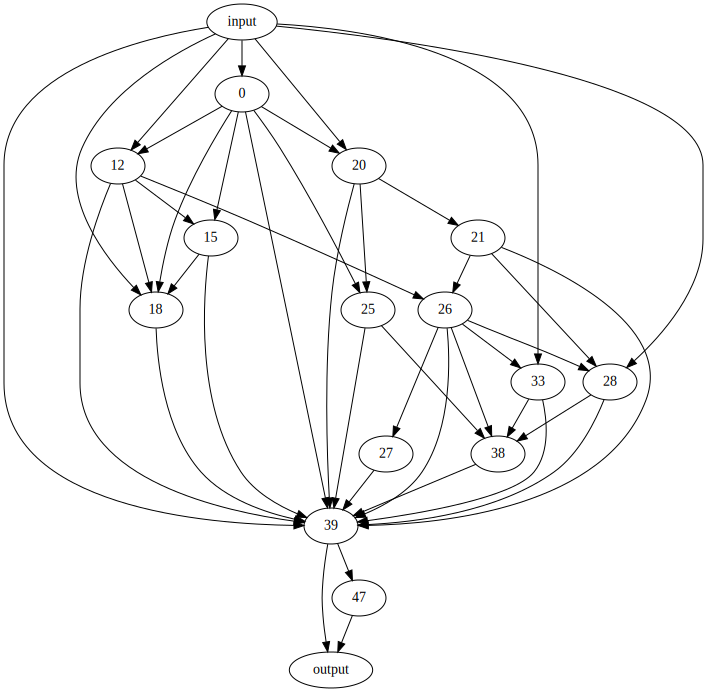

/home/dev/mamba_interp/out_dot.png

In [43]:
# sudo apt-get install graphviz
# sudo apt-get install xdg-utils

import tempfile
from PIL import Image
draw_graphviz(edges=edges)
import networkx as nx
G = get_graphviz_graph(edges=edges)
f_path = "out_dot"
G.render(f_path, format='png') 
from IPython.display import FileLink, display
display(FileLink(f_path + ".png"))

In [8]:
f
global edges
global all_nodes
import cloudpickle
with open("backup_items_785.pkl", "wb") as f:
    cloudpickle.dump([edges, all_nodes], f)

tensor([[ 0.3646, -0.2458, -0.3552,  1.3923],
        [ 1.5787, -1.4617, -0.8949, -0.6481]])

## Probing

In [ ]:
from sklearn.linear_model import LinearRegression

# we want to predict the name from the representation
# there are two ways to do this:
# 1. Predict the probability of a rep being a name (output logits for each name)
# 2. Output the name embedding
# we'll start with the second one because it is more general, if that doesn't work we can try the first one


# we're basically doing a tuned lens sorta? idk
# lets start with not batched

# okay so say we are trying to output the name embedding
# on layer i, that could mean:
#    predict emb after it's projected into E space (which is after norm, but before conv)
#    predict emb after conv
#    predict emb after conv and silu
#    predict emb from hidden state or some other internal rep
# the point is that we train this linear map for some specific thing, then how well it performs suggests how well that thing encodes our data,
# so we can try it for lots of intermediate stuff
# some of the maps won't work, that's ok


B,L = batched_data.size()

# find all token positions that differ in the data (these are the things we want to predict)
positions_that_vary = {}
for i in range(batched_data.size()[1]):
    unique_values = torch.unique(batched_data[:,i])
    if unique_values.size()[0] > 1:
        positions_that_vary[i] = unique_values

# for each position that varies, for each other position, fit a linear model

global probing_dataset_X
probing_dataset_X = []
def dataset_gathering_hook(
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int
):
    global probing_dataset_X
    probing_dataset_X.append(x[:,position,:])
    return x

     


for position, values in positions_that_vary.items():
    # debug ouptuts
    values = sorted(list(values))
    
    print(f"position {position} has the following values:")
    for tok in values:
        print(f"  tok {tok} {repr(model.tokenizer.decode([tok.item()]))}")

    value_to_class = {}
    for i, tok in enumerate(values):
        value_to_class[tok] = i
        
    # make dataset
    
    def get_linear_classification_dataset(data, hooks):
        global probing_dataset_X
        probing_dataset_X = []
        _ = model.run_with_hooks(batched_data, fwd_hooks=)
        probing_dataset_X = torch.cat(probing_dataset_X, dim=0)
        probing_dataset_X = probing_dataset_X.detach().cpu().numpy()

        probing_dataset_Y = np.zeros([B,len(values)])
        probing_dataset_Y[:] = -1 # predict a vector with -1 for incorrect class and 1 for correct class
        for i in range(data.size()[0]):
            value = data[i,position]
            probing_dataset_Y[i,value_to_class[i]] = 1

        return probing_dataset_X, probing_dataset_Y
    
    # todo: try all positions instead of just a specific position
    for layer in range(model.cfg.n_layers):
        for other_position in range(L):  
            print(f"layer {layer} position {other_position}")
            
            hook = partial(dataset_gathering_hook, position=other_position)
            hooks = [(f'blocks.{layer}.hook_layer_input', hook)]
            X, Y = get_linear_classification_dataset(data=batched_data, hooks=hooks)
            model = LinearRegression()
            model.fit(X, Y)
            vX, vY = get_linear_classification_dataset(data=vbatched_data, hooks=hooks)
            pY = model.predict(vX)
            for i in range(10):
                print("  ", vY[i], pY[i])
            
        

print(f"these token positions vary their value: {positions_that_vary}")




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 684.4 kB/s eta 0:00:00 0:00:01
